<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='top'></a>
# Digit Recognition
Harrison Henningsen (he/him)

[Portfolio](https://internetweb.site/portfolio)

[LinkedIn](https://www.linkedin.com/in/hi-im-harrison/)

## Table of Contents
Note on HTML jump links: [Open in nbviewer](https://nbviewer.org/github/hhboorstein/ds_portfolio/blob/main/Digit_Recognition.ipynb) to use jump links.

[Data Exploration](#data_exploration)

[Functions](#functions)

[Fully-Connected Neural Network](#fullnet)

[Convolutional Neural Network](#convnet)

# Setup

We will explore digit classification using PyTorch and the MNIST dataset. We implement two neural networks: a fully-connected network and a convolutional network.

## Libraries

In [1]:
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_chisquare, proportions_ztest
from sklearn.metrics import confusion_matrix, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import clear_output

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

import torchvision

In [2]:
# set plotting theme with blank grids
sns.set_theme(rc={'grid.linestyle':''})

In [3]:
# for documentation reference
torch.__version__

'2.0.0+cu118'

## Set environment params

For repeatability of results, we fix a random seed.

In [4]:
# set random seed
torch.manual_seed(57)

In [5]:
# set batch sizes
batch_train=64
batch_test=1000

## CUDA Setup

In [6]:
# CUDA version for documentation reference
torch.version.cuda

'11.8'

In [7]:
(dev:=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

device(type='cuda')

We check that CUDA is available. We use the device flag `dev` later to marshal tensors and models to the GPU.

## Data

In [8]:
# define transformation sequence
transformations=[
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), # MNIST global mean
        (0.3081) # MNIST global std dev
    )
]

[From MNIST training mean and standard deviation.](https://datascience.stackexchange.com/questions/46228/how-mean-and-deviation-come-out-with-mnist-dataset)

In [9]:
# source MNIST data
data_train=torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(transformations)
)

data_test=torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(transformations)
)

100%|██████████| 9912422/9912422 [00:00<00:00, 260911409.27it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33196956.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 114948747.55it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14377757.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# define training data
train_loader=DataLoader(
    dataset=data_train,
    batch_size=batch_train,
    shuffle=True
)

# define test data
test_loader=DataLoader(
    dataset=data_test,
    batch_size=batch_test,
    shuffle=True
)

We download the MNIST data, convert to tensors and normalize, and define our data loaders. Recall that the training batch size is 64 and the testing batch size is 1000.

Lastly, we download test images from [my GitHub](https://github.com/hhboorstein/ds_portfolio). These are hand-drawn by me and will serve as an out-of-sample benchmark. They are stored as PyTorch tensors.

In [11]:
# download test images and labels
# stored in personal GitHub as PyTorch tensors

num_test_imgs=14

# labels
!wget -P /content/Test_Imgs/ 'https://github.com/hhboorstein/ds_portfolio/raw/main/Resources/Test_Digit_Tensors/labels.pt'

# images
for i in range(num_test_imgs):
  url=f'https://github.com/hhboorstein/ds_portfolio/raw/ffe7c8ad4f1eb100610942bab4371d4cfd347dc4/Resources/Test_Digit_Tensors/img_tensor_{i}.pt'
  !wget -P /content/Test_Imgs/ {url}

clear_output()

<a name='data_exploration'></a>
# Data Exploration

In [12]:
# get a batch
imgs,labels=next(iter(train_loader))

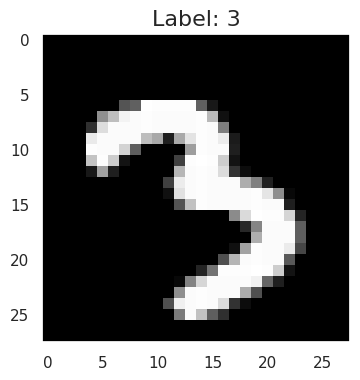

In [13]:
plt.figure(figsize=(4,4))
plt.title(f'Label: {labels[0]}',fontsize=16)
plt.imshow(imgs[0].squeeze(),cmap='gray');

Each record is a $28\times 28$ grayscale image with a corresponding label.

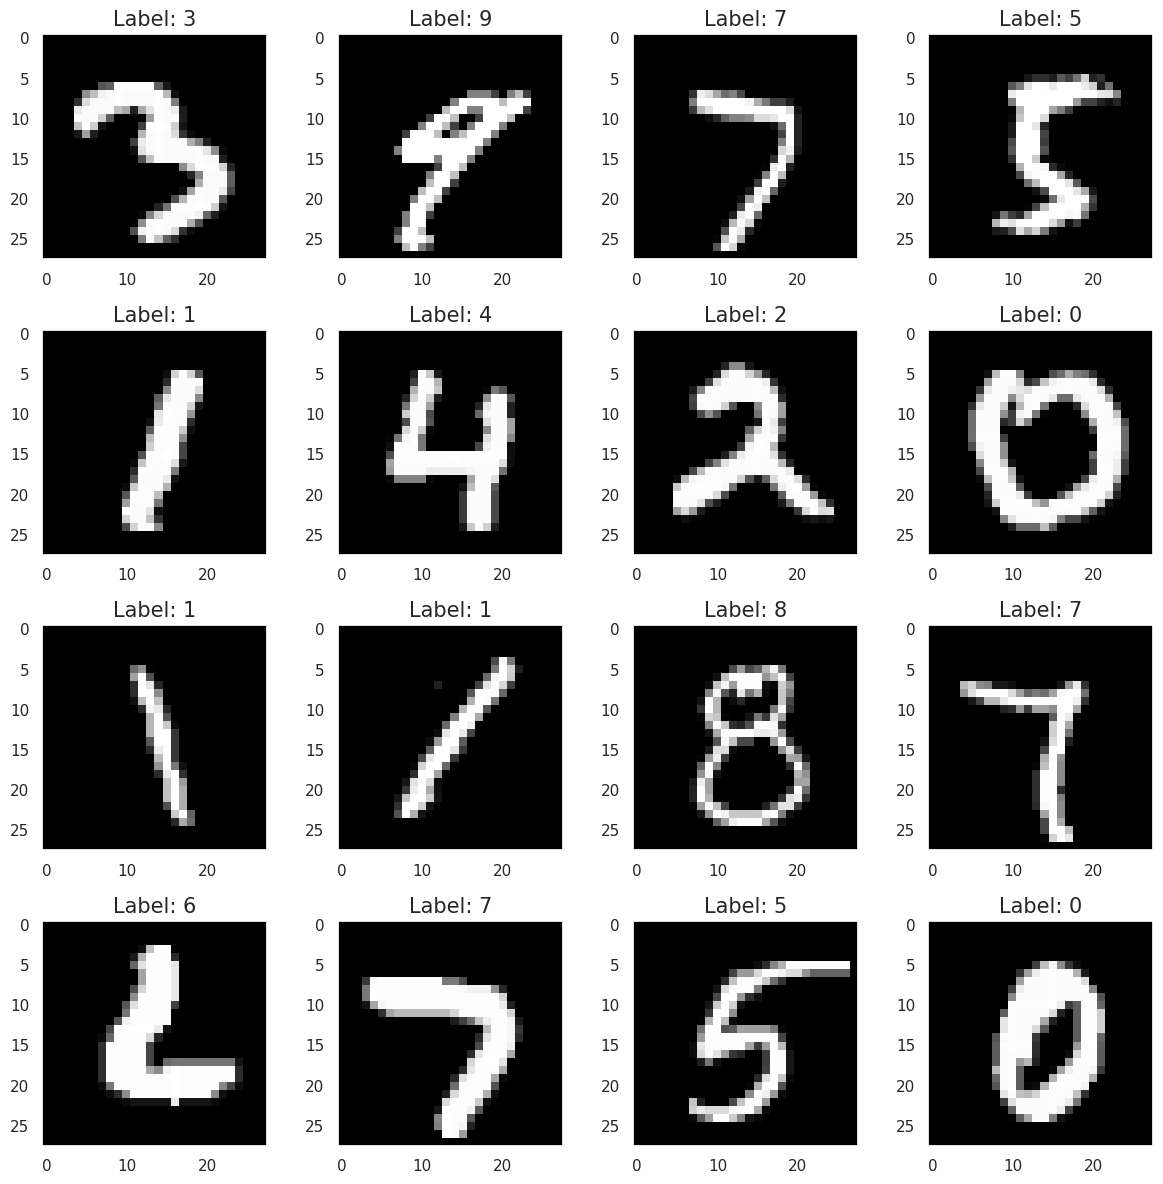

In [14]:
# plot samples
fig,ax=plt.subplots(4,4,figsize=(12,12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.title(f'Label: {labels[i]}',fontsize=15)
  plt.imshow(imgs[i].squeeze(),cmap='gray')
fig.tight_layout()
plt.show()

Some entries are more legible than others. There is a good variety of orintations too.

## Imbalance

To investigate potential imbalance, we collect all labels in the training set.

In [15]:
labels_full=pd.Series([data_train[i][1] for i in range(60000)])

In [16]:
labels_full.value_counts().sort_values()

5    5421
4    5842
8    5851
6    5918
0    5923
9    5949
2    5958
3    6131
7    6265
1    6742
dtype: int64

There is certainly some imbalance. Label frequency ranges from 5421/60000 (label 5) to 6742/60000 (label 1). Note that a perfectly balanced dataset would have 6000 entries for each of the 10 classes. Visually:

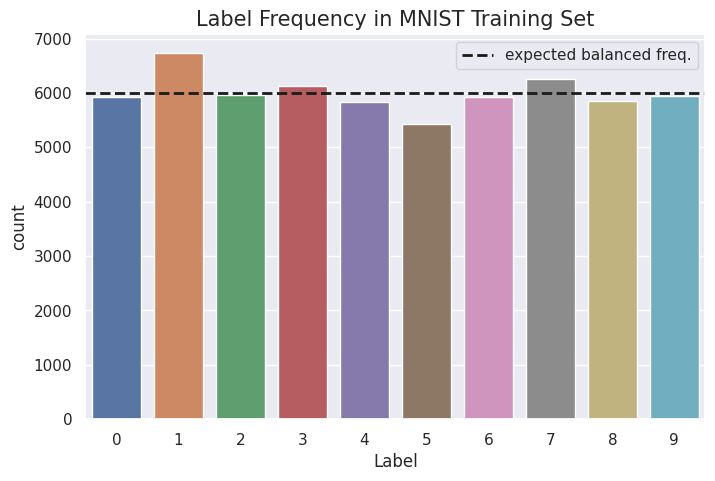

In [17]:
with sns.axes_style(rc={'grid.linestyle':'-'}):
  plt.figure(figsize=(8,5))
  plt.title('Label Frequency in MNIST Training Set',fontsize=15)
  sns.countplot(x=labels_full)
  plt.axhline(
      y=6000,
      color='k',
      linestyle='--',
      linewidth=2,
      label='expected balanced freq.')
  plt.xlabel('Label')
  plt.legend();

We see that classes 1 and 5 deviate appreciably from 6000. The question is: Assuming a level of significance of 5%, is there evedence that these classes are _truly_ imbalanced.

We perform a chi-squared test of proportions. The true value against which our frequencies will be measured is 0.1 (or 10%). A p-value less than 0.05 indicates that there is true deviation in at least one class from this 10% figure.

In [18]:
# chi-squared test for dataset balance inquiry
freqs=labels_full.value_counts().tolist()
train_nobs=[60000 for i in range(10)]

_,pval,(_,_)=proportions_chisquare(
    count=freqs,
    nobs=train_nobs,
    value=0.1
)

print(f'''With a p-value of {pval}, we can conclude
that there is imbalance in the MNIST dataset.''')

With a p-value of 7.124517413614377e-36, we can conclude
that there is imbalance in the MNIST dataset.


Indeed, there is statistically significant imbalance in our dataset. Using now a two-proportions z-test, we can determine which classes skew too far from 10% representation.

Once more, we assume a level of significance of 5%. Our null hypothesis is that there is no statistical difference between the frequency of a particular class and the balanced 6000/60000. The alternate hypothesis is that the class frequency does indeed deviate.

In [19]:
# two-proportions z-test for each digit
pval_dict={}
for key in (label_dict:=labels_full.value_counts().to_dict()):
  _,pval=proportions_ztest(
      count=[label_dict[key],6000],
      nobs=[60000,60000]
  )
  pval_dict[key]=pval

# print results, annotate rejections
for digit,pval in enumerate(pd.Series(pval_dict).sort_index()):
  status=('reject' if pval<0.05 else 'fail to reject')
  annot=('*' if pval<0.05 else ' ')
  print(f'''{annot+str(digit)}: We {status} the null hypothesis
  with a p-value of {pval}.\n''')

 0: We fail to reject the null hypothesis
  with a p-value of 0.4574473727151762.

*1: We reject the null hypothesis
  with a p-value of 3.580597236007005e-12.

 2: We fail to reject the null hypothesis
  with a p-value of 0.6856424615469848.

 3: We fail to reject the null hypothesis
  with a p-value of 0.209665965204355.

 4: We fail to reject the null hypothesis
  with a p-value of 0.1261785990783033.

*5: We reject the null hypothesis
  with a p-value of 1.2289419334341624e-08.

 6: We fail to reject the null hypothesis
  with a p-value of 0.4286786623656247.

*7: We reject the null hypothesis
  with a p-value of 0.011557788056848121.

 8: We fail to reject the null hypothesis
  with a p-value of 0.1493746194861904.

 9: We fail to reject the null hypothesis
  with a p-value of 0.6229471156193913.



Those classes that deviate (p-value < 0.05) are annotated with an astrisk. Along with 1, we find that 7 is also appreciably overrepresented. And while 4 and 8 are somewhat underrepresented, their p-values are slightly too high to be considered definitively imbalanced. Accordingly, 5 is the only appreciably underrepresented class.

<a name='functions'></a>
# Functions

We collect all our functions in one place.

## Training

This first function trains the network over one epoch. It records losses and saves both the network state and optimizer state so training can be resumed later if required.

In [20]:
# make directory for saving training states
!mkdir training_results

def train_epoch(network,epoch_id):
  'One epoch of NN training.'

  network.train()

  print(f'Epoch {epoch_id} Training')
  for batch_id,(x,y) in enumerate(train_loader):
    # send tensors to preset device
    x,y=x.to(dev),y.to(dev)

    # loss calculation and back propagation
    opt.zero_grad()
    loss=L(network(x),y)
    loss.backward()
    opt.step()
    
    # record losses by (partial) epoch
    epochs.append(epoch_id+batch_id/load_len)
    losses.append(loss.item())

    # print progress
    if batch_id%175==0:
      p=100*(batch_id/load_len)
      print(f'{int(p)}% completed with loss {np.round(loss.item(),4)}')

  # save internal state
  torch.save(network.state_dict(),f'./training_results/network_{network.name}.pth')
  torch.save(opt.state_dict(),f'./training_results/optimizer_{network.name}.pth')

  return

Next is the test function, which evaluates network performance on the test dataset. It prints the average loss and the accuracy.

In [21]:
def test(network):
  '''Compute average loss and prediction
  accuracy of NN on test data.'''

  total_loss,num_correct=0,0
  network.eval()

  with torch.no_grad():
    for x,y in test_loader:
      # send to device
      x,y=x.to(dev),y.to(dev)

      # predict
      out=network(x)

      # loss and accuracy calculations
      total_loss+=L(out,y).item()
      y_hat=out.max(dim=1,keepdim=True)[1]
      num_correct+=y_hat.eq(y.view_as(y_hat)).sum()
  
  # print stats
  test_avg_losses.append(w:=total_loss/len(test_loader))
  print(f'avg loss: {w}')
  print(f'% correct: {100*num_correct/len(test_loader.dataset)}')
  return total_loss,num_correct

## Model Analysis

The next function computes a confusion matrix and accuracy for a given data loader and model. The diagonals show the *percent* accuracy for the network's prediction of that label, while the other entries of the matrix show the *number* of misclassification occurances. Since our dataset has label imbalance, showing percentages on the diagonal aids in interpretation far more than the plain count.

In [58]:
def cm(dl,network,test=False):
  '''Generate a confusion matrix of
  NN results for a given data loader.
  Returns confusion matrix and accuracy.'''

  y_pred=[]
  y_true=[]
  network=network.to('cpu')
  network.eval()

  print('Predicting...')
  with torch.no_grad():
    # collect predictions and actuals
    for x,y in dl:
      y_pred.extend(network(x).max(dim=1)[1].numpy())
      y_true.extend(y.numpy())

  # make cm
  print('Generating confusion matrix...')
  cmat=confusion_matrix(
      y_true,
      y_pred,
      labels=np.arange(10)
  )

  acc=accuracy_score(y_true,y_pred)

  # generate label matrix
  annot_lbls=np.copy(cmat).astype(str)
  ser=pd.Series(y_true).value_counts().sort_index()
  for i in range(10):
    annot_lbls[i][i]=str(np.round(100*cmat[i][i]/ser[i],2))+'%'

  # plotting
  clear_output()

  # proper title
  if test==False:
    title='Training Data'
  else:
    title='Test Data'

  plt.figure(figsize=(12,8))
  plt.title(f'{title} Confusion Matrix ({100*np.round(acc,2)}% accuracy)',fontsize=16)

  # heatmap confusion matrix
  sns.heatmap(
      data=cmat,
      annot=annot_lbls,
      cmap='Greens',
      cbar=False,
      fmt='s'
  )

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()
  
  return

This visual analysis tool prints the given digit image and plots the network's prediction. It compares the label with the prediction.

In [23]:
def eval(img,label,network):
  'Evaluate network prediction.'
  
  network=network.to('cpu')
  network.eval()

  # prediction
  with torch.no_grad():
    y=network(img)
  # positive shift
  y=y+torch.abs(y.min())
  # percentage calculation
  sm=sum(y)
  perc=[]
  for idx in y:
    perc.append((idx/sm).item())

  # series of sorted percentages
  s=pd.Series(perc).sort_values(ascending=False)
  s.index=pd.CategoricalIndex(s.index)

  # plot image and prediction bar graph
  fig=plt.figure(figsize=(14,5))

  # digit and label
  ax1=fig.add_subplot(1,2,1)
  plt.title(f'Label: {label}',fontsize=20)
  plt.imshow(img.squeeze(),cmap='gray')

  # check if prediction is correct
  if torch.argmax(y)==label:
    state='Correct Prediction!'
    style='k'
  else:
    state=f'Incorrect Prediction: {torch.argmax(y)}'
    style='r'

  # prediction confidence graph
  with sns.axes_style(rc={'grid.linestyle':'-'}):
    ax2=fig.add_subplot(1,2,2)
    plt.title(state,color=style,fontsize=20)
    sns.barplot(x=s.values,y=s.index,order=s.index)
  
  fig.tight_layout()
  plt.show()
  
  return torch.argmax(y)

This last analysis function evaluates a network on my custom, hand-drawn dataset. I think the handwriting is at least as good as those in the MNIST dataset.

In [24]:
def eval_oos(model):
  '''Prints evaluation graphic for 
  my hand-drawn (out-of-sample) digits.'''

  # get labels
  lbls=torch.load('Test_Imgs/labels.pt')
  num_errors=0

  # evaluate network on test images
  for i in range(num_test_imgs):
    pred=eval(
      torch.load(f'Test_Imgs/img_tensor_{i}.pt'),
      int(lbls[i]),
      model
    )
    if pred!=int(lbls[i]):
      num_errors+=1

  # print error rate
  print()
  print(f'{num_errors} out of {num_test_imgs} misclassified.')
  
  return

<a name='fullnet'></a>
# Fully-Connected Neural Network


In [25]:
class DigitClfr(nn.Module):

  def __init__(self):
    
    super(DigitClfr,self).__init__()
    self.name='FullNet'

    self.Linear1=nn.Linear(28**2,1024)
    self.Linear2=nn.Linear(1024,256)
    self.Linear3=nn.Linear(256,64)
    self.Linear4=nn.Linear(64,10)

  def forward(self,x):
    x=x.view(-1,28**2)
    x=F.relu(self.Linear1(x))
    x=F.relu(self.Linear2(x))
    x=F.relu(self.Linear3(x))
    x=self.Linear4(x)
    return x.squeeze()

We begin by defining our network. It inherits properties of the superclass `torch.nn.Module`. The network is comprised of four fully-connected layers.

In [26]:
# initialize network
nwk=DigitClfr().to(dev)

# loss function
L=nn.CrossEntropyLoss()

# optimizer
opt=SGD(nwk.parameters(),lr=0.01)

We measure cost with cross entropy loss, which we minimize using stochastic gradient descent.

## Testing Forward Pass

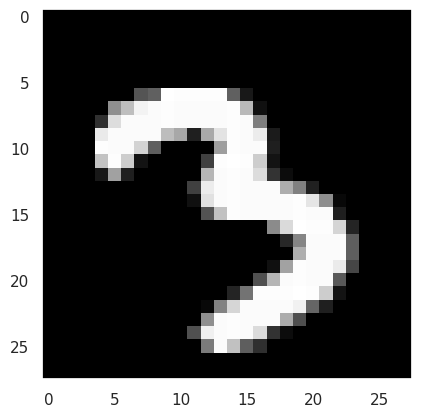

In [27]:
# input image
plt.imshow(imgs[0].squeeze(),cmap='gray');

We run the above image through the (untrained) network to confirm everything is properly set up.

In [28]:
# probability density function tensor 
# containing (currently random) predictions
(test_out:=nwk(imgs[0].squeeze().to(dev)))

tensor([-0.0349,  0.0862, -0.0684, -0.0928,  0.1223,  0.0380, -0.1017,  0.0375,
        -0.0797, -0.0825], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [29]:
test_out.shape

torch.Size([10])

Output tensor shape is correct. We get 10 probabilities: one for each digit label.

In [30]:
# cross entropy loss
L(test_out,labels[0].to(dev)).item()

2.3807878494262695

The cost function yields a loss of about 2.38 for this example.

## Training

In [31]:
# bookkeeping
epochs,losses=[],[]
test_avg_losses=[]
load_len=len(train_loader)
acc_factor=100/len(test_loader.dataset)
per_epoch_acc=[]

# pretrain benchmark
test(nwk)
print('='*50)

# 10 epoch training
for i in range(1,11):

  train_epoch(nwk,i)

  print('='*50)

  # post-epoch benchmark
  _,count=test(nwk)
  per_epoch_acc.append(count.item()*acc_factor)

  print('='*50)

avg loss: 2.3028570652008056
% correct: 8.550000190734863
Epoch 1 Training
0% completed with loss 2.3183
18% completed with loss 1.9573
37% completed with loss 0.8805
55% completed with loss 0.5752
74% completed with loss 0.5825
93% completed with loss 0.3211
avg loss: 0.3739812016487122
% correct: 89.3499984741211
Epoch 2 Training
0% completed with loss 0.3147
18% completed with loss 0.2938
37% completed with loss 0.3522
55% completed with loss 0.2582
74% completed with loss 0.2932
93% completed with loss 0.5959
avg loss: 0.26310197860002515
% correct: 92.18000030517578
Epoch 3 Training
0% completed with loss 0.1908
18% completed with loss 0.2039
37% completed with loss 0.1841
55% completed with loss 0.2875
74% completed with loss 0.2234
93% completed with loss 0.1237
avg loss: 0.2098824694752693
% correct: 93.8699951171875
Epoch 4 Training
0% completed with loss 0.2895
18% completed with loss 0.1843
37% completed with loss 0.3184
55% completed with loss 0.2183
74% completed with loss

## Performance Assessment

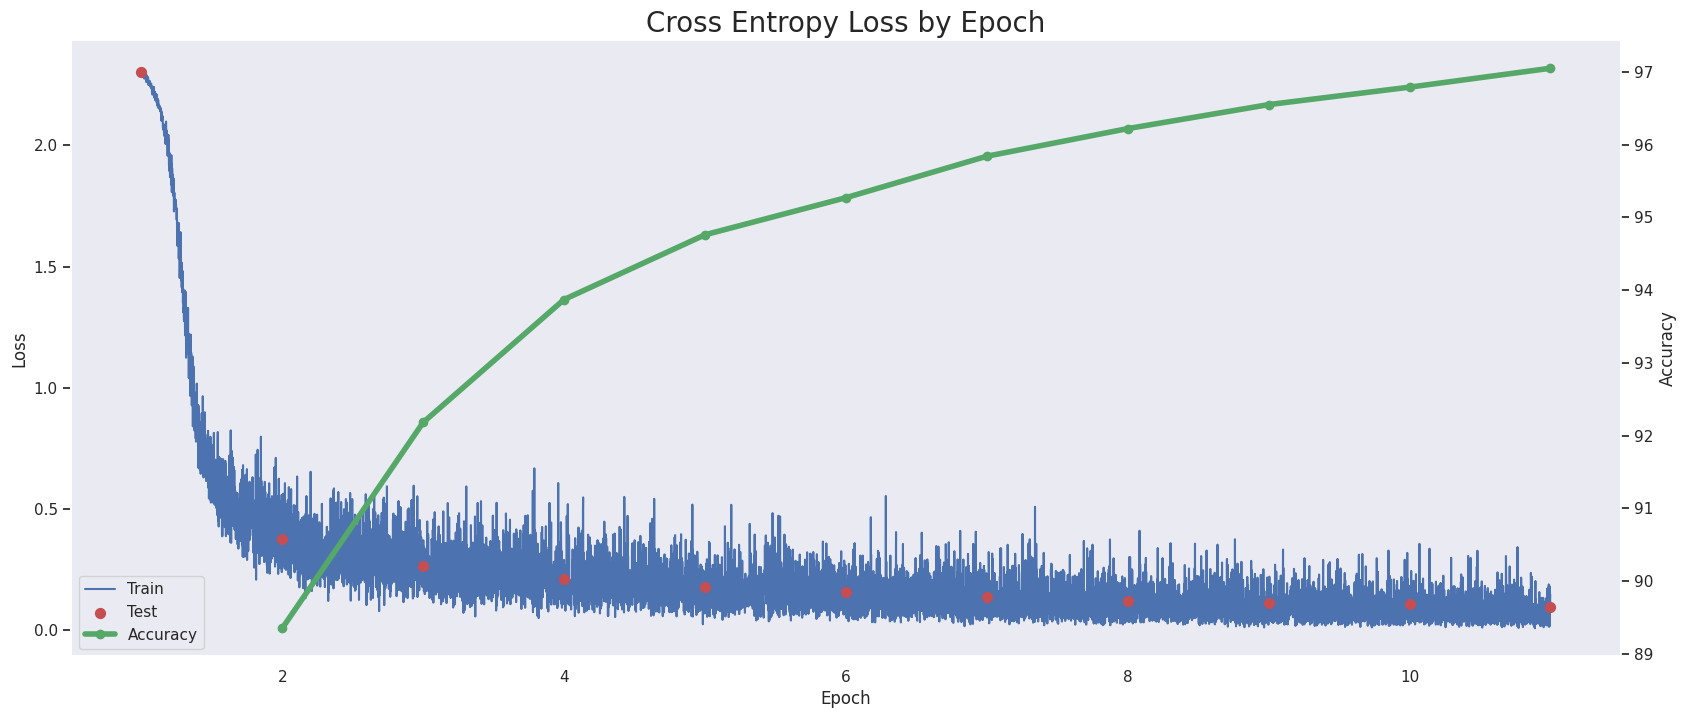

In [32]:
fig,ax1=plt.subplots(figsize=(20,8))
ax2=ax1.twinx()

plt.title('Cross Entropy Loss by Epoch',fontsize=20)

# loss plots
g1=ax1.plot(
    epochs,
    losses,
    label='Train',
    zorder=0
)
g2=ax1.scatter(
    x=np.arange(1,12),
    y=test_avg_losses,
    c='r',
    s=50,
    label='Test'
)

# accuracy plot
g3=ax2.plot(
    np.arange(2,12),
    per_epoch_acc,
    lw=4,
    marker='o',
    c='g',
    label='Accuracy'
)

# axes labels
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

# legend setup
graph1,label1=ax1.get_legend_handles_labels()
graph2,label2=ax2.get_legend_handles_labels()
ax2.legend(
    graph1+graph2,
    label1+label2,
    loc='lower left')

plt.show()

After 10 training epochs, our loss has decreased drastically. We see with that a corresponding increase in accuracy, up to 97% on test data!

We can further analyize our model's performance using a confusion matrix.

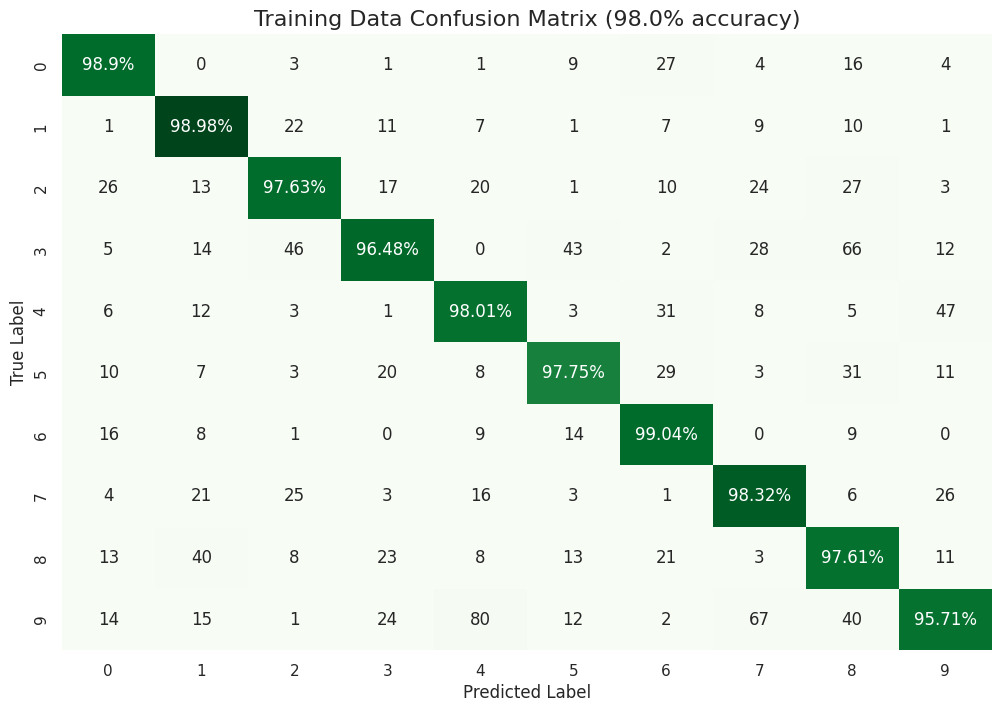

In [59]:
# training data prediction analysis
cm(train_loader,nwk)

Label accuracy hovers between 96% and almost 99%. Additionally, we see that 0 is never predicted to be 1. On the opposite extreme, there were plenty of 9s that were predicted to be 4s and many 3s predicted to be 8s. Similarity in numeral shapes likely accounts for these errors.

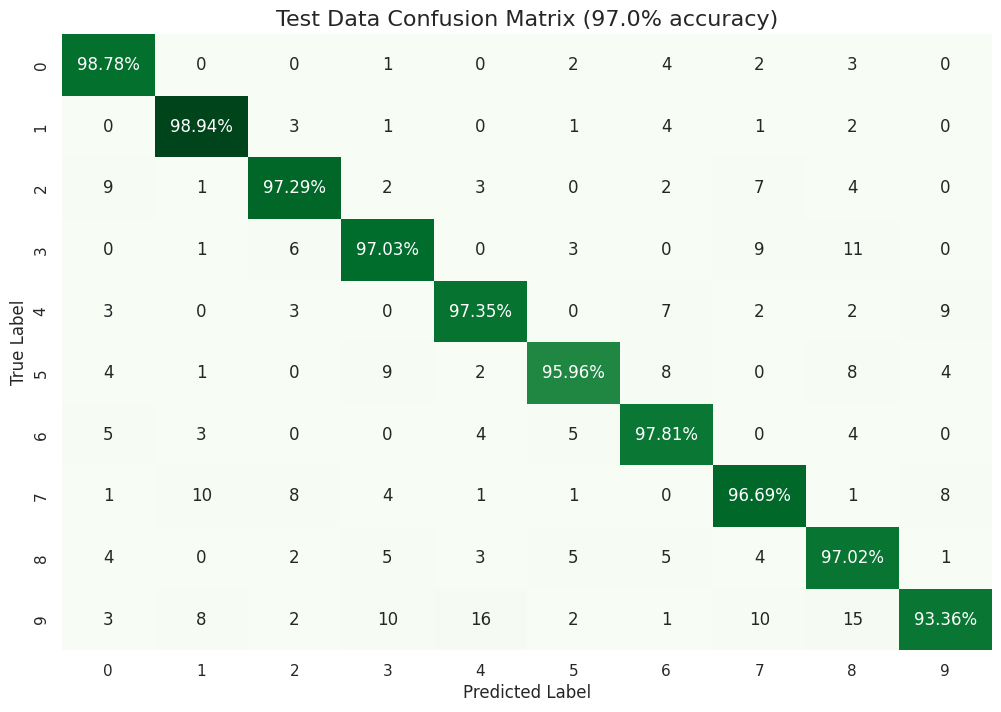

In [60]:
# testing data predction analysis
cm(test_loader,nwk,1)

Similar findings to the above can be observed in the test data predictions.
<a name='nwk_eval_test_sample'></a>

In [35]:
# re-assign these variables to the test dataloader
imgs,labels=next(iter(test_loader))

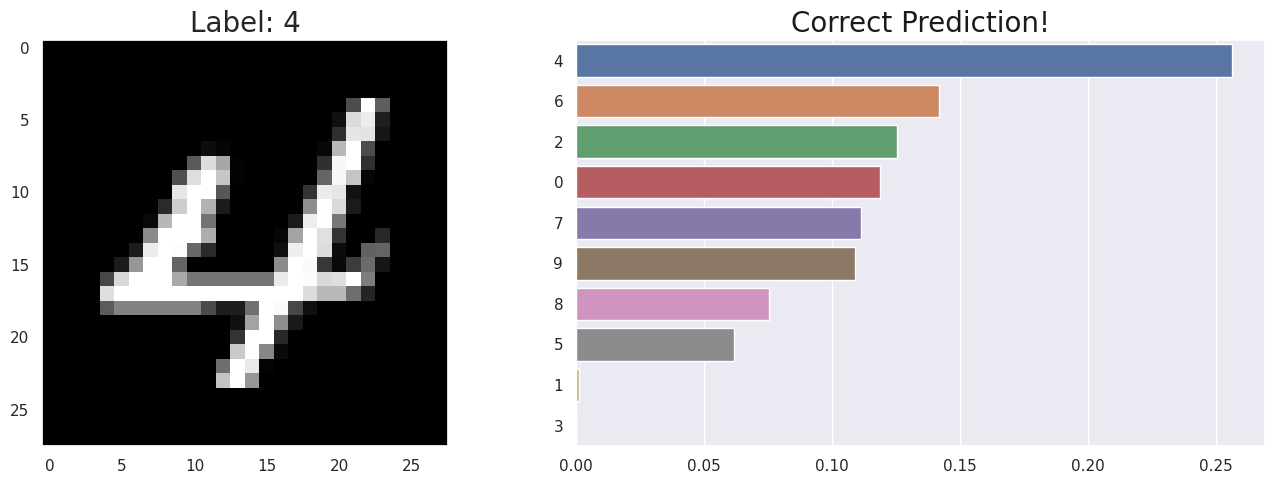

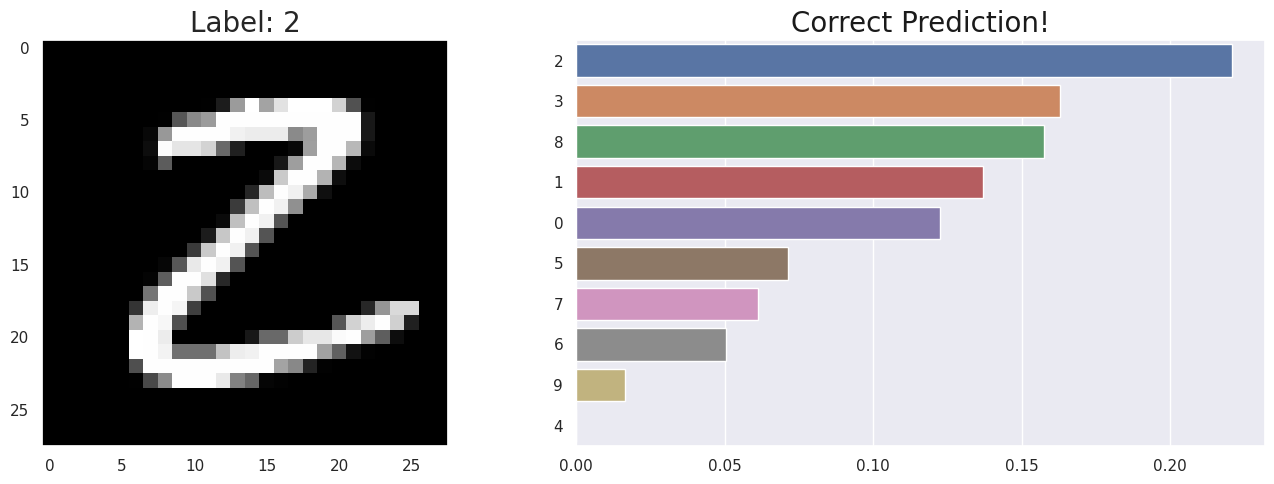

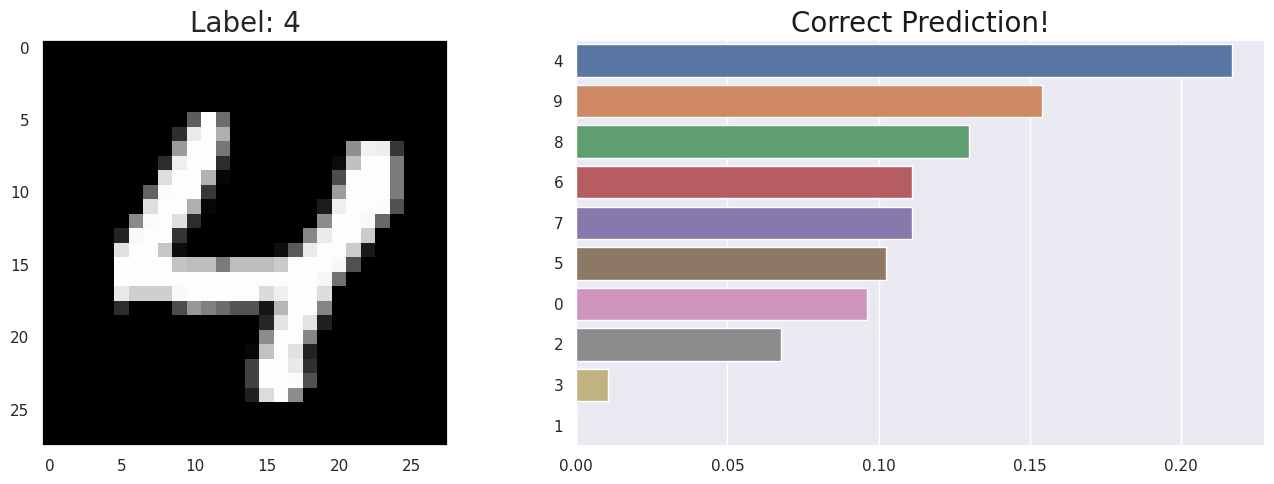

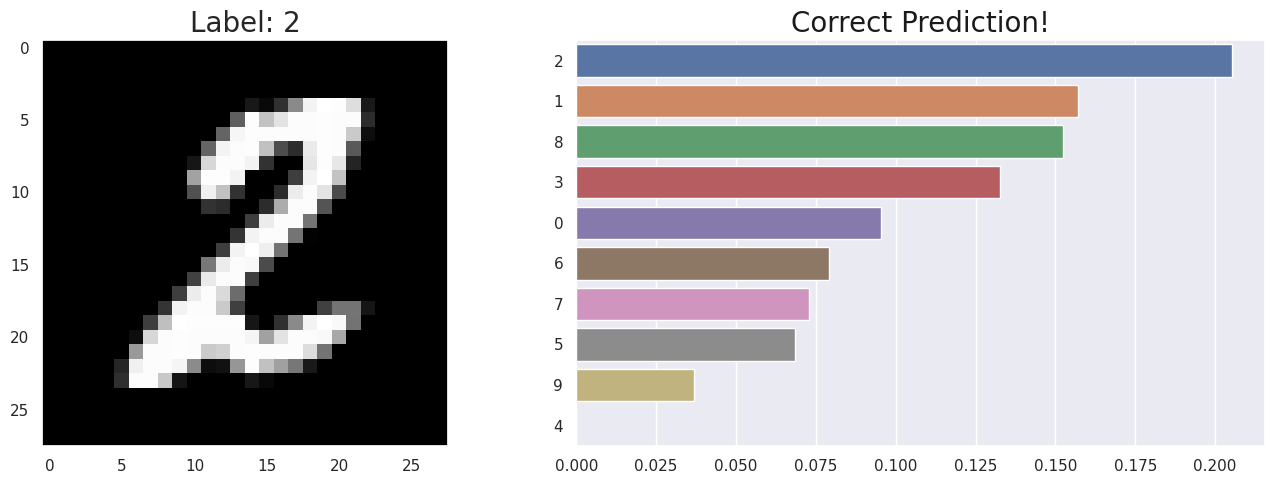

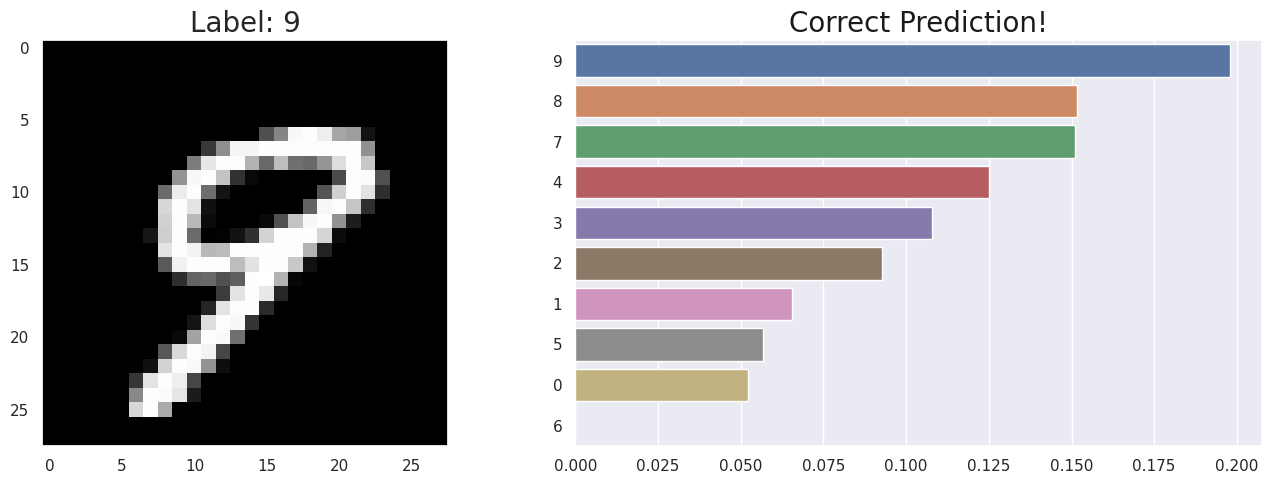

In [36]:
# evaluate on images from test dataloader
for i in np.random.randint(1000,size=5):
  eval(imgs[i],labels[i],nwk)

Pulling the first few examples from the test set, we see the performance of our model. Note that, while the predictions are correct, the model's confidence is fairly weak and nearly every label is shown as a possibility.

(If you jumped up here from later analyses, you can [jump back](#cnn_oos) to convolutional neural network performance.)

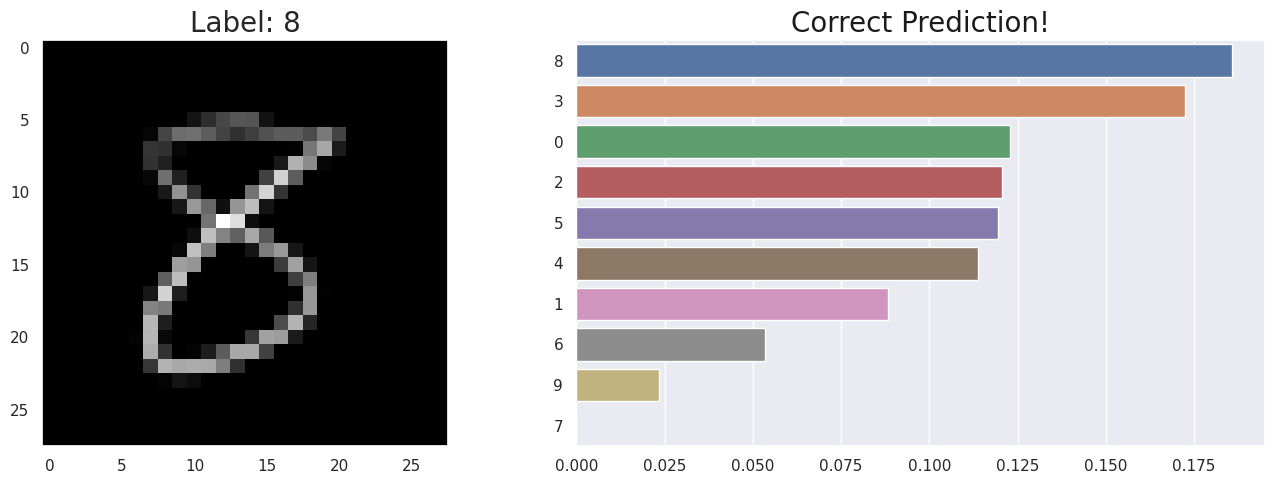

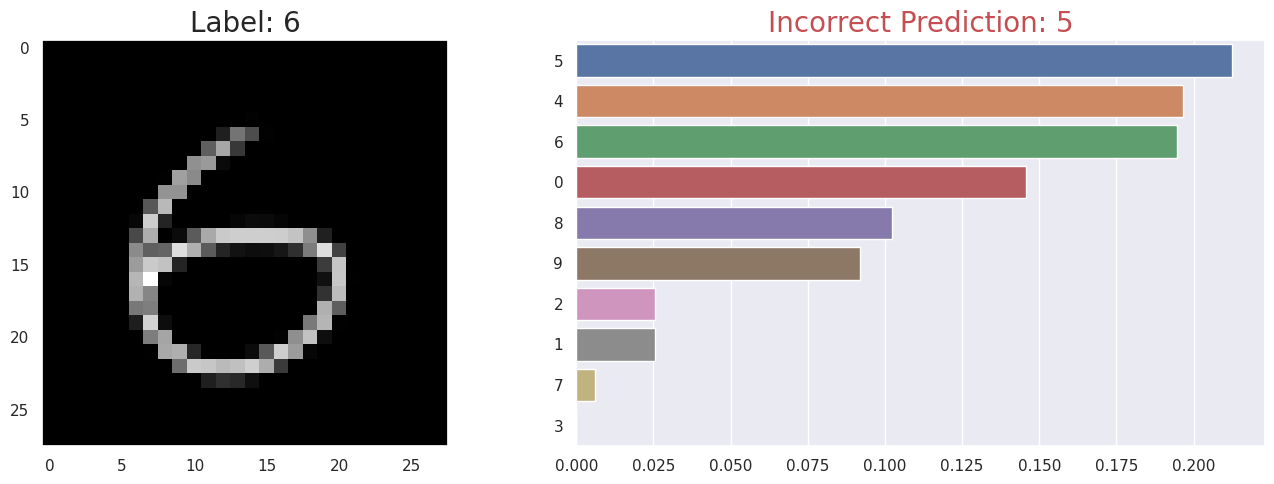

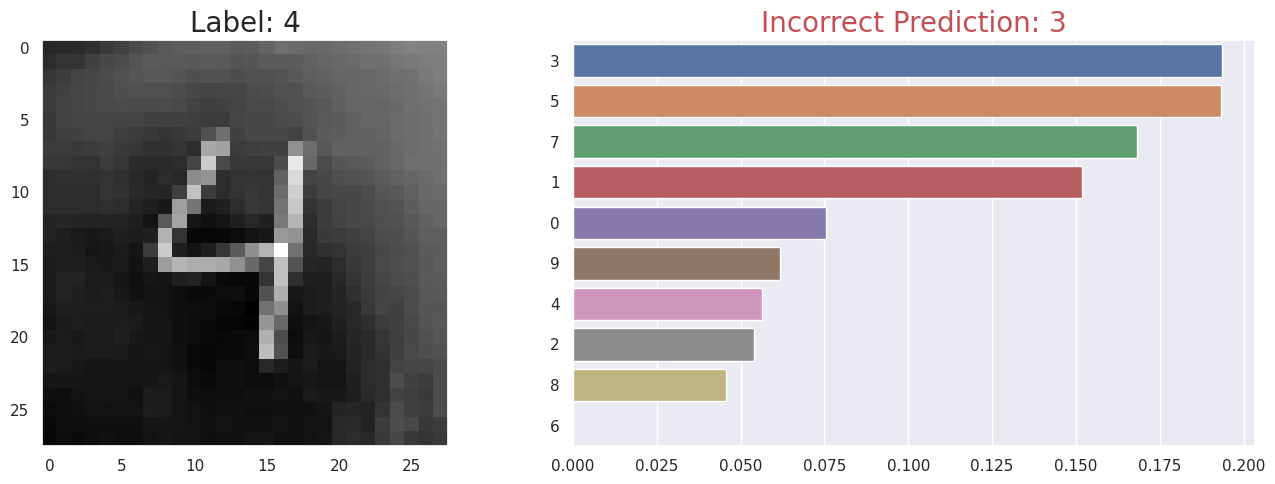

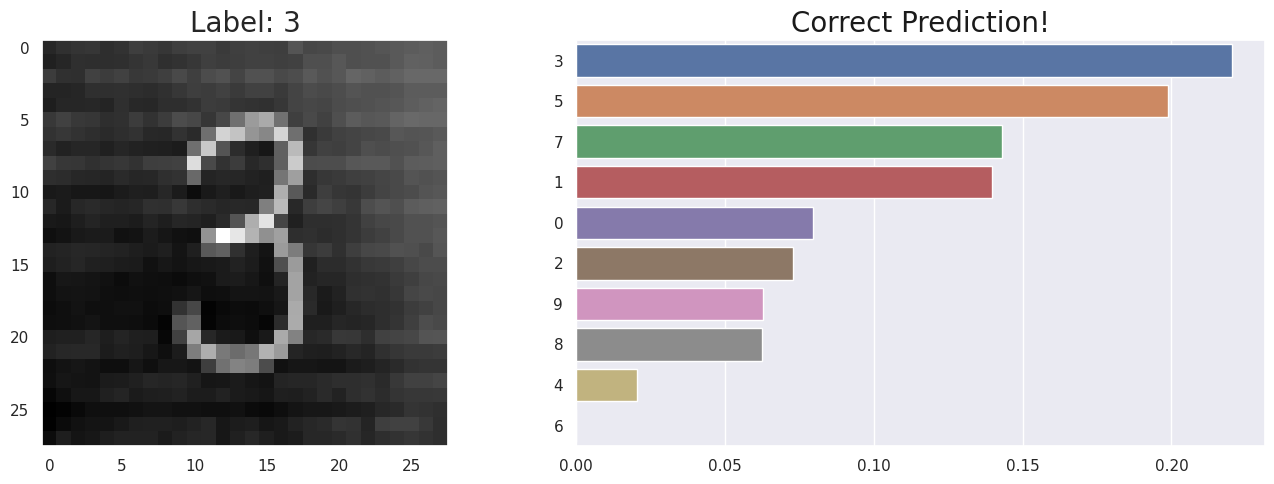

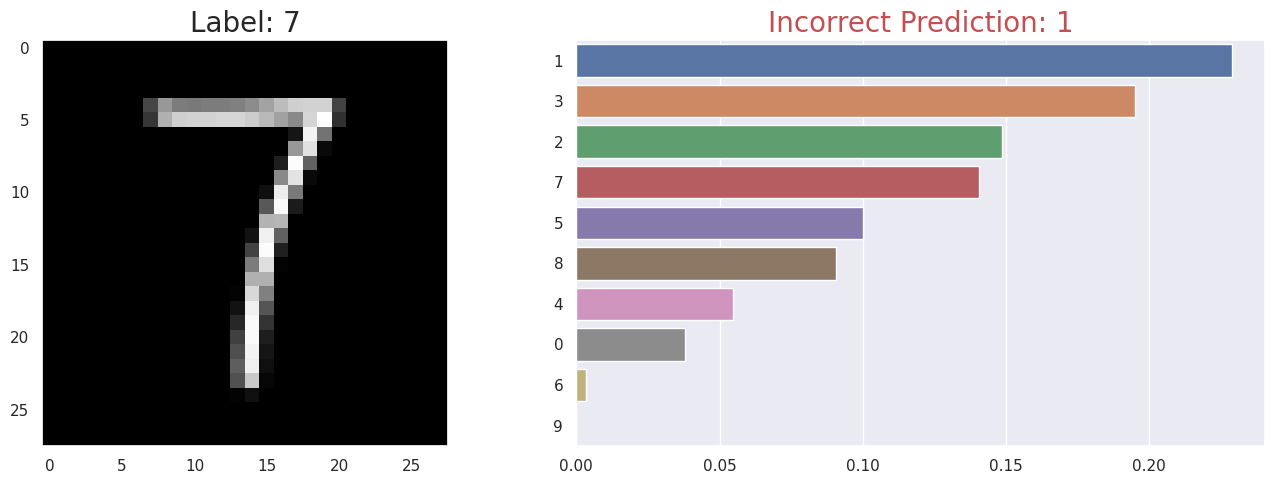

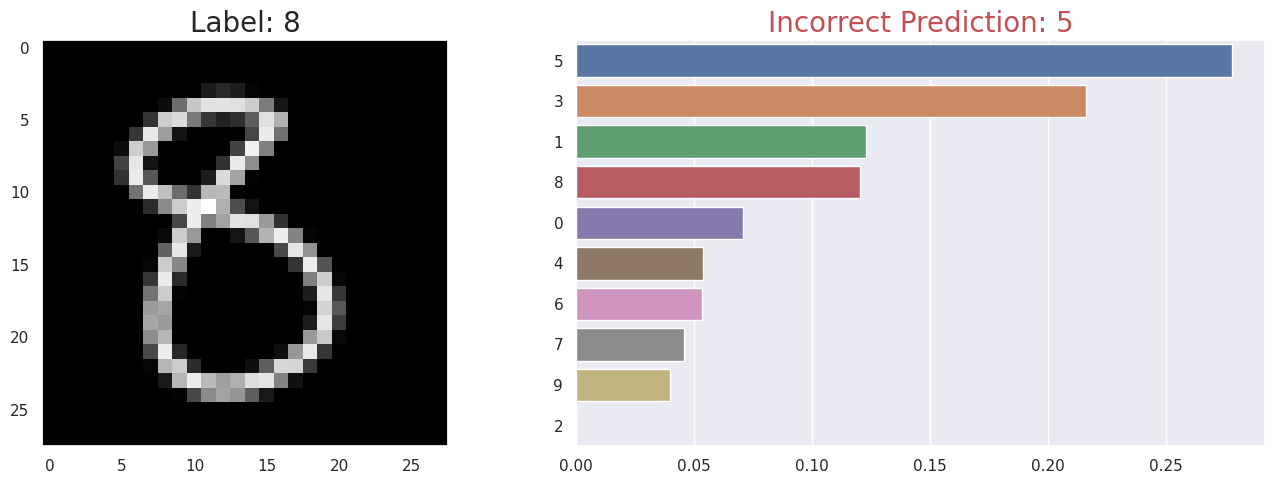

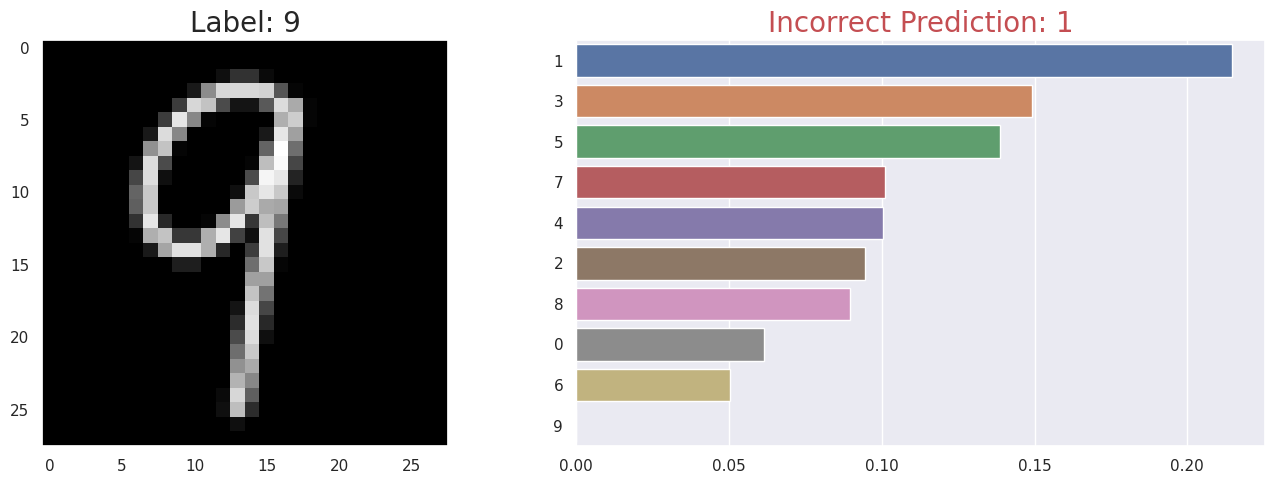

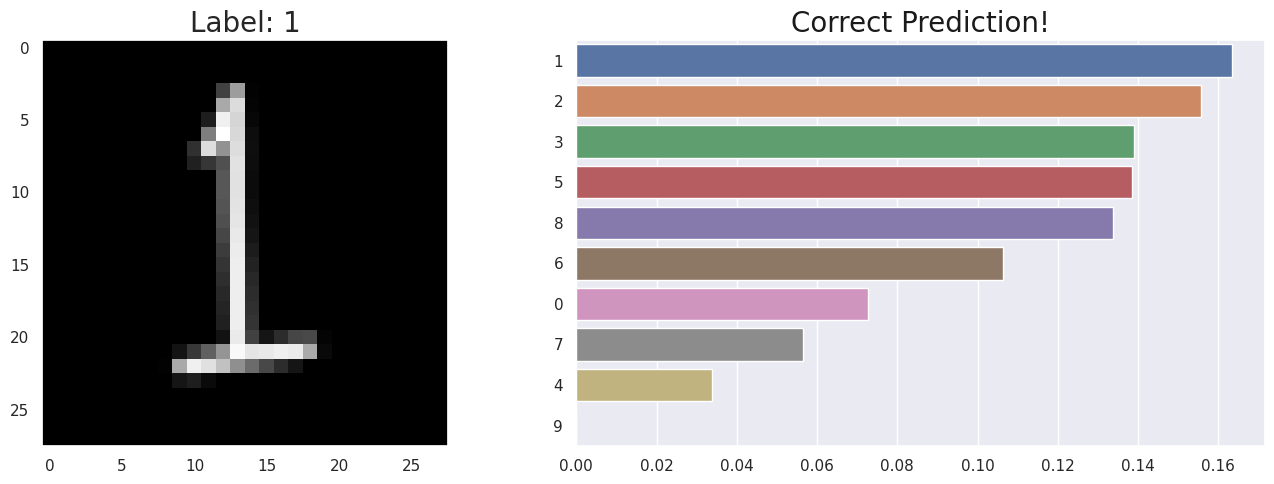

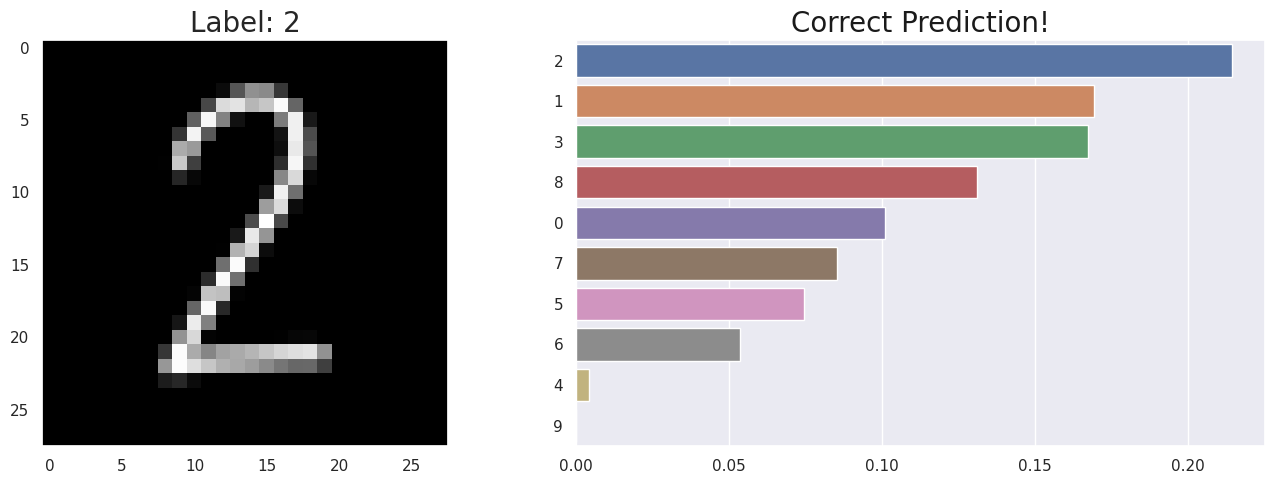

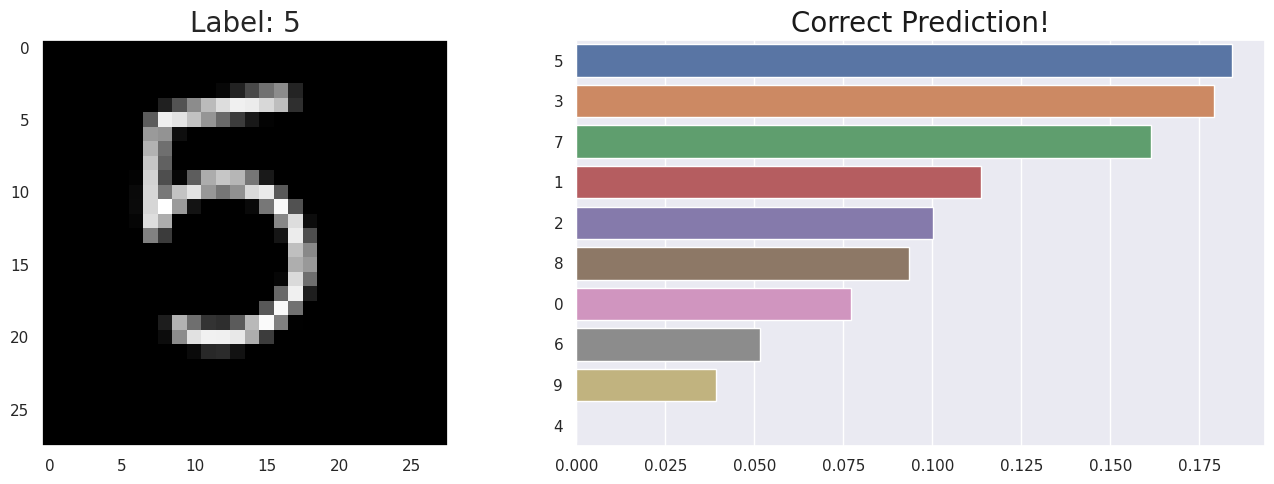

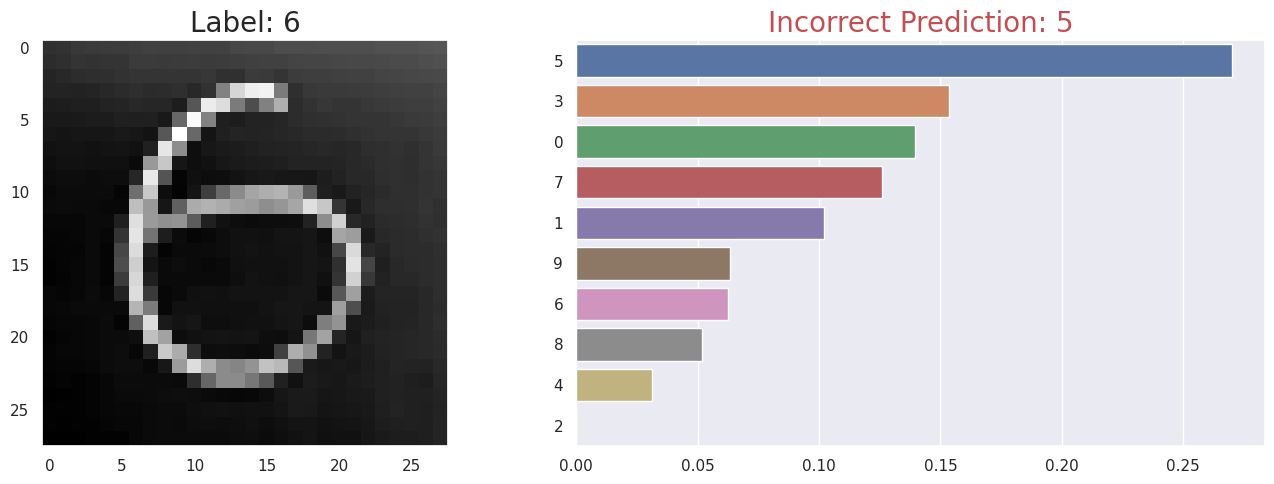

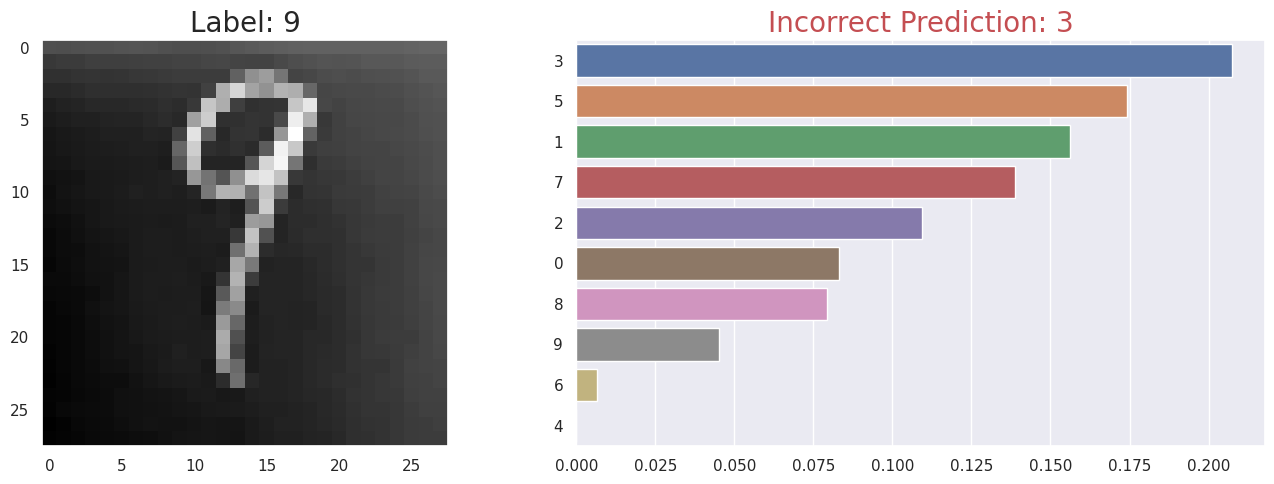

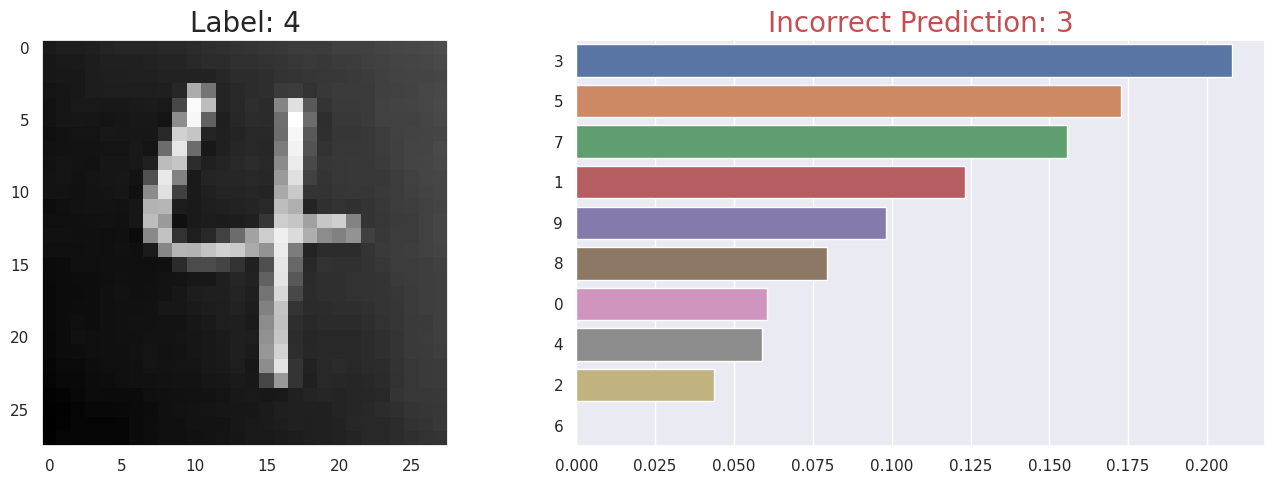

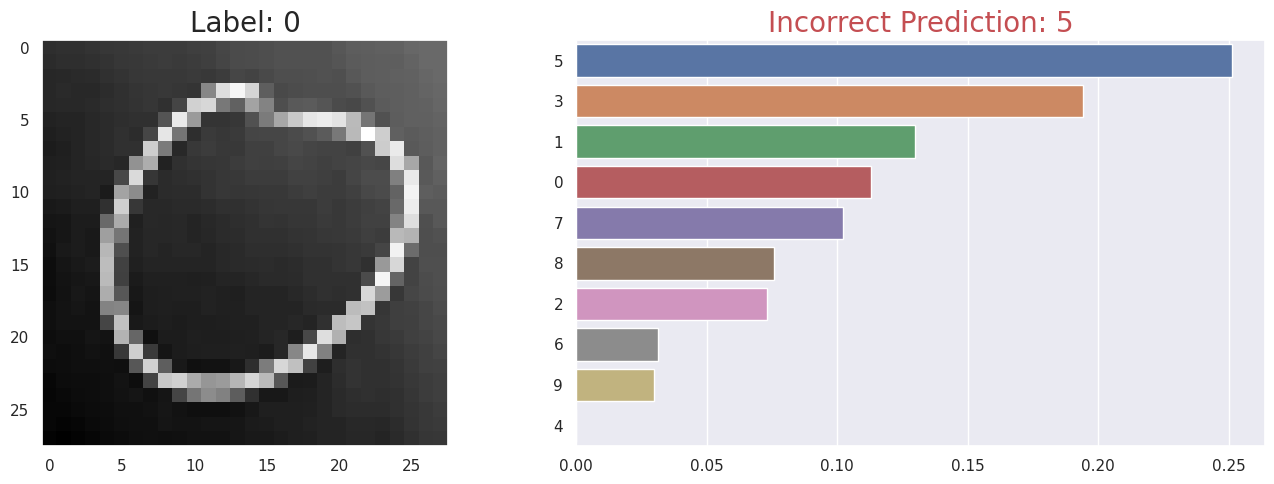


9 out of 14 misclassified.


In [37]:
# check performance on custom out-of-sample data
eval_oos(nwk)

With such a high percentage of misclassified digits, we have to wonder what is going on. My current hypothesis is that the model relies on a thicker stroke, so digits with narrow lines, like those above, fare worse.

<a name='convnet'></a>
# Convolutional Neural Network

Next we define the structure for a convolutional neural network.

In [38]:
class DigitCNN(nn.Module):

  def __init__(self):

    super(DigitCNN,self).__init__()
    self.name='ConvNet'

    self.Conv1=nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        padding=2
    )
    self.Conv2=nn.Conv2d(
        in_channels=16,
        out_channels=64,
        kernel_size=5,
        padding=2
    )
    self.Pool=nn.MaxPool2d(
        kernel_size=2,
        stride=2
    )
    self.Linear1=nn.Linear(7*7*64,2048)
    self.Linear2=nn.Linear(2048,256)
    self.Linear3=nn.Linear(256,10)
    self.Drop=nn.Dropout(p=0.5)


  def forward(self,x):
    # feature learning
    x=F.relu(self.Conv1(x))
    x=self.Pool(x)
    x=F.relu(self.Conv2(x))
    x=self.Pool(x)

    # classificaiton
    x=x.view(-1,7*7*64)
    x=F.relu(self.Linear1(x))
    x=self.Drop(x)
    x=F.relu(self.Linear2(x))
    x=self.Drop(x)
    x=F.relu(self.Linear3(x))

    return x.squeeze()

Along with convolution layers and max-pooling layers, this network has dropout layers between the fully-connected layers. These dropout layers randomly turn off neurons during training, reducing the risk of overfitting.

In [39]:
# initialize network
cnn=DigitCNN().to(dev)

# loss function
L=nn.CrossEntropyLoss()

# optimizer
opt=SGD(cnn.parameters(),lr=0.01)

We initialize our network, loss function, and optimizer to start training.

## Training

In [40]:
# bookkeeping
epochs,losses=[],[]
test_avg_losses=[]
load_len=len(train_loader)
acc_factor=100/len(test_loader.dataset)
per_epoch_acc=[]

# pretrain benchmark
test(cnn)
print('='*50)

# 10 epoch training
for i in range(1,11):

  train_epoch(cnn,i)

  print('='*50)

  # post-epoch benchmark
  _,count=test(cnn)
  per_epoch_acc.append(count.item()*acc_factor)

  print('='*50)

avg loss: 2.3035120725631715
% correct: 8.960000038146973
Epoch 1 Training
0% completed with loss 2.3105
18% completed with loss 2.1193
37% completed with loss 0.678
55% completed with loss 0.467
74% completed with loss 0.1937
93% completed with loss 0.1703
avg loss: 0.19763219207525254
% correct: 93.95999908447266
Epoch 2 Training
0% completed with loss 0.1981
18% completed with loss 0.2905
37% completed with loss 0.199
55% completed with loss 0.2258
74% completed with loss 0.2222
93% completed with loss 0.1401
avg loss: 0.10149771049618721
% correct: 96.87999725341797
Epoch 3 Training
0% completed with loss 0.1105
18% completed with loss 0.1369
37% completed with loss 0.0844
55% completed with loss 0.1175
74% completed with loss 0.1579
93% completed with loss 0.1031
avg loss: 0.0692764263600111
% correct: 97.79000091552734
Epoch 4 Training
0% completed with loss 0.0807
18% completed with loss 0.0825
37% completed with loss 0.0103
55% completed with loss 0.0672
74% completed with loss

Impressive gains in just ten epochs. See more detail below.

## Performance Assessment

Let's visualize the training. Below we plot the loss and accuracy by epoch.

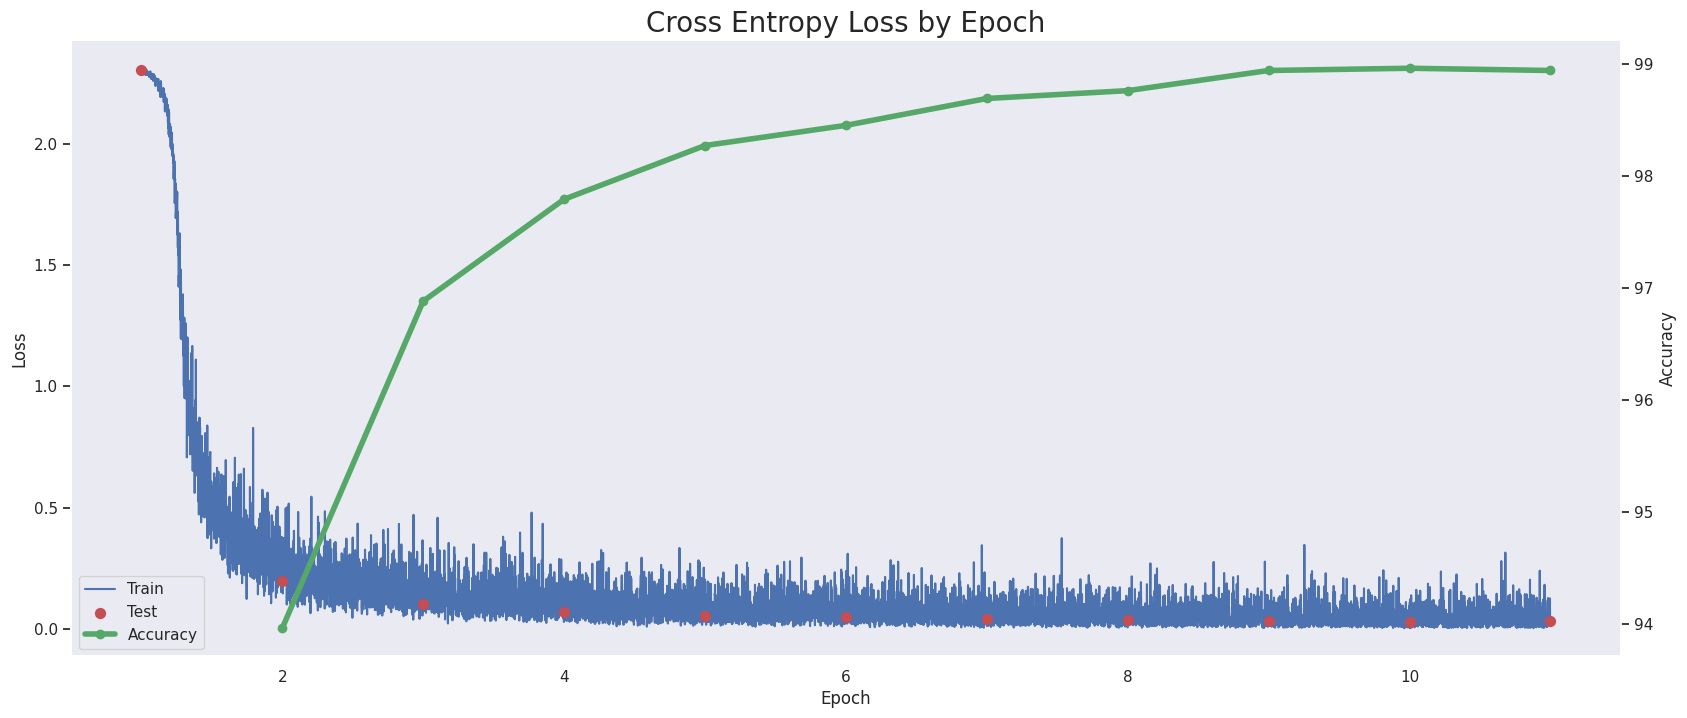

In [41]:
fig,ax1=plt.subplots(figsize=(20,8))
ax2=ax1.twinx()

plt.title('Cross Entropy Loss by Epoch',fontsize=20)

# loss plots
g1=ax1.plot(
    epochs,
    losses,
    label='Train',
    zorder=0
)
g2=ax1.scatter(
    x=np.arange(1,12),
    y=test_avg_losses,
    c='r',
    s=50,
    label='Test'
)

# accuracy plot
g3=ax2.plot(
    np.arange(2,12),
    per_epoch_acc,
    lw=4,
    marker='o',
    c='g',
    label='Accuracy'
)

# axes labels
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

#graphs=g1+g2+g3
#labels=[g.get_label() for g in graphs]

graph1,label1=ax1.get_legend_handles_labels()
graph2,label2=ax2.get_legend_handles_labels()

ax2.legend(
    graph1+graph2,
    label1+label2,
    loc='lower left')
plt.show()

By the end of 10 epochs, training loss has essentially leveled off, with at most a mild amount of noise. Accuracy is nearly 99%!

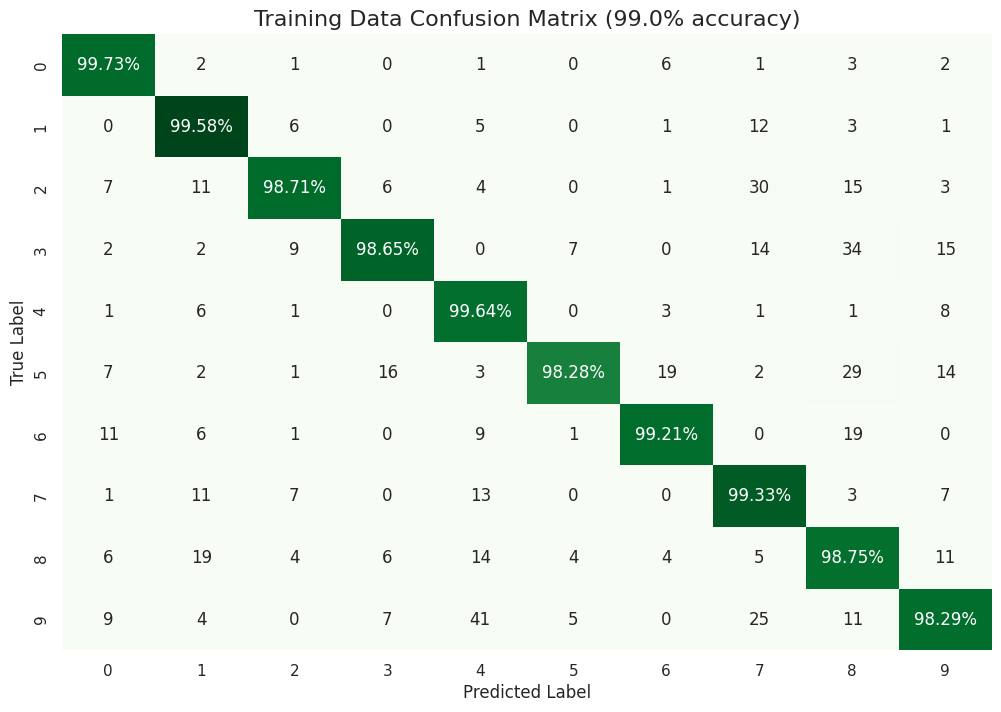

In [61]:
# training data prediction analysis
cm(train_loader,cnn)

We see here that predictions on training data do not score below 98.75% for any label. The most accurately predicted label is 0, with 99.68% accuracy!

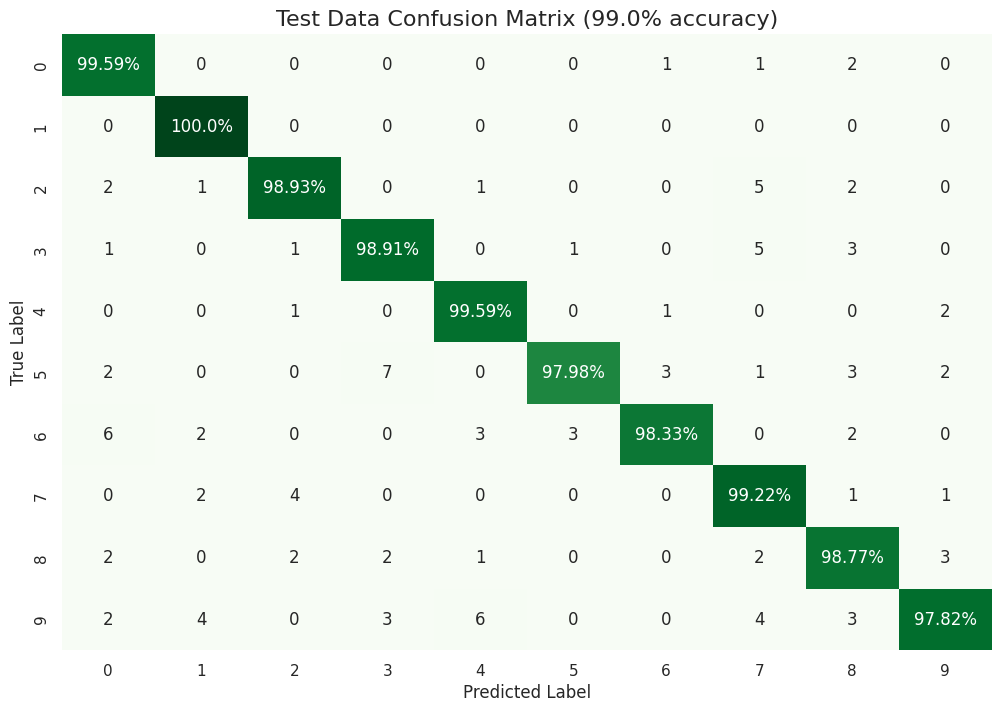

In [62]:
# test data prediction analysis
cm(test_loader,cnn,1)

We can even look at the confidence of predictions.

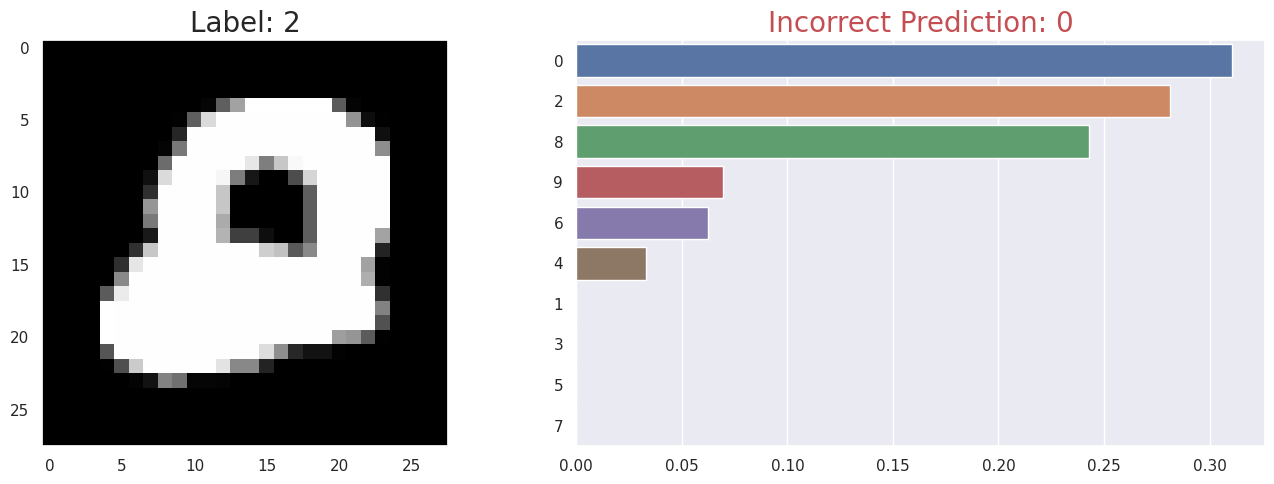

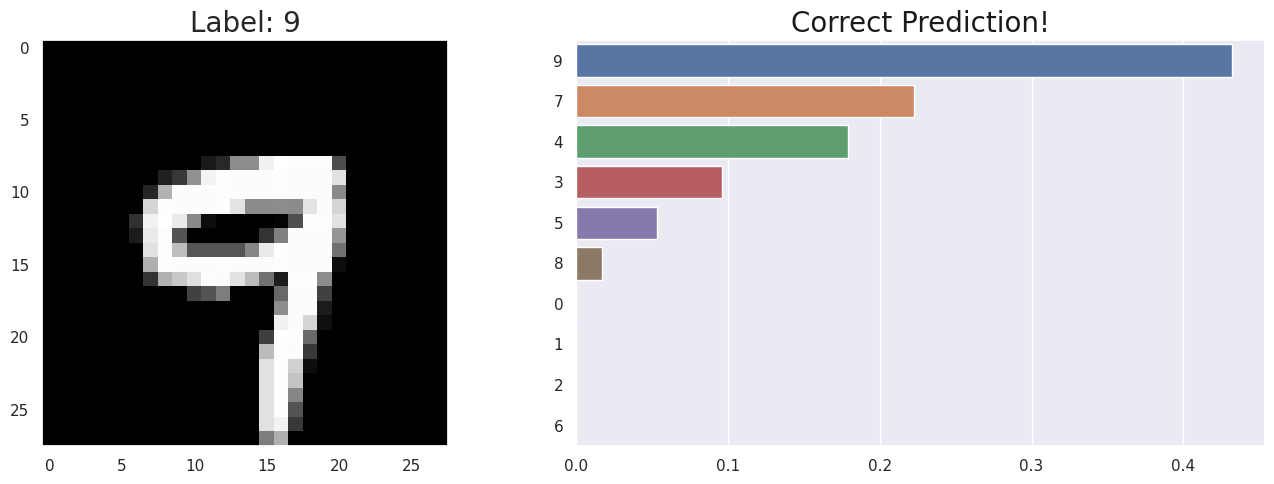

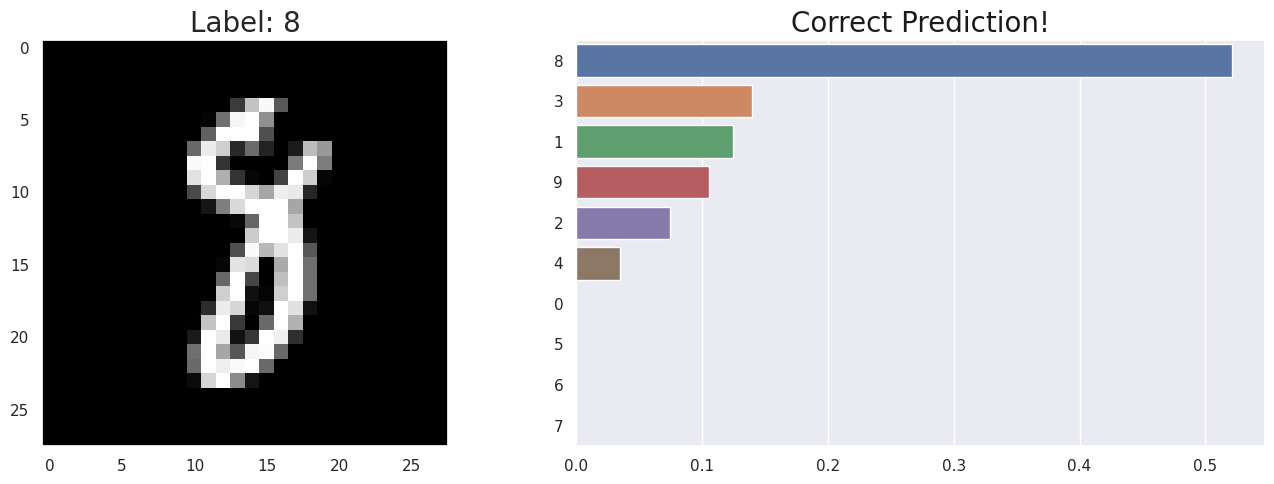

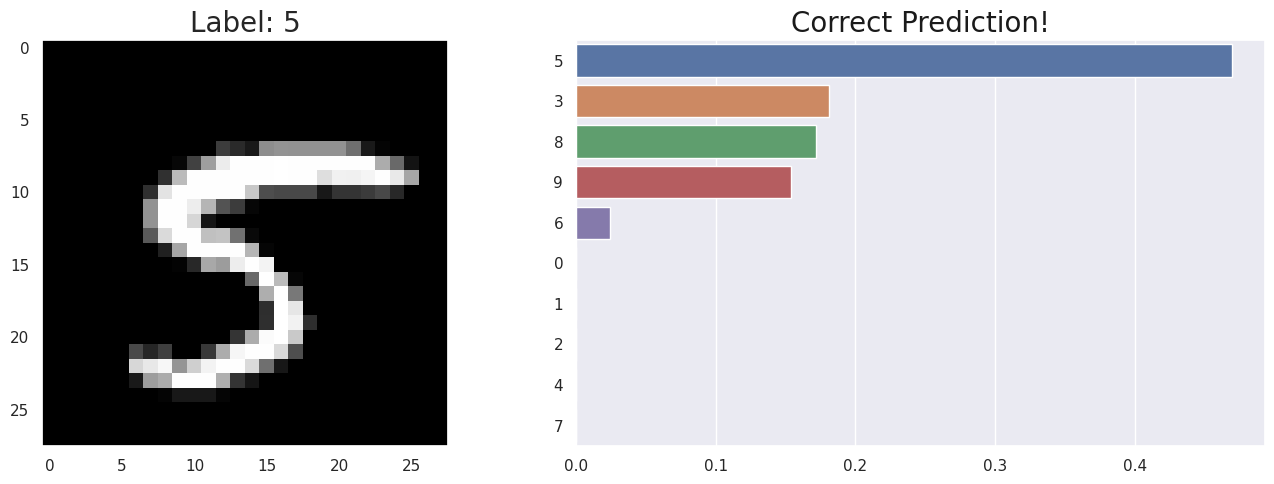

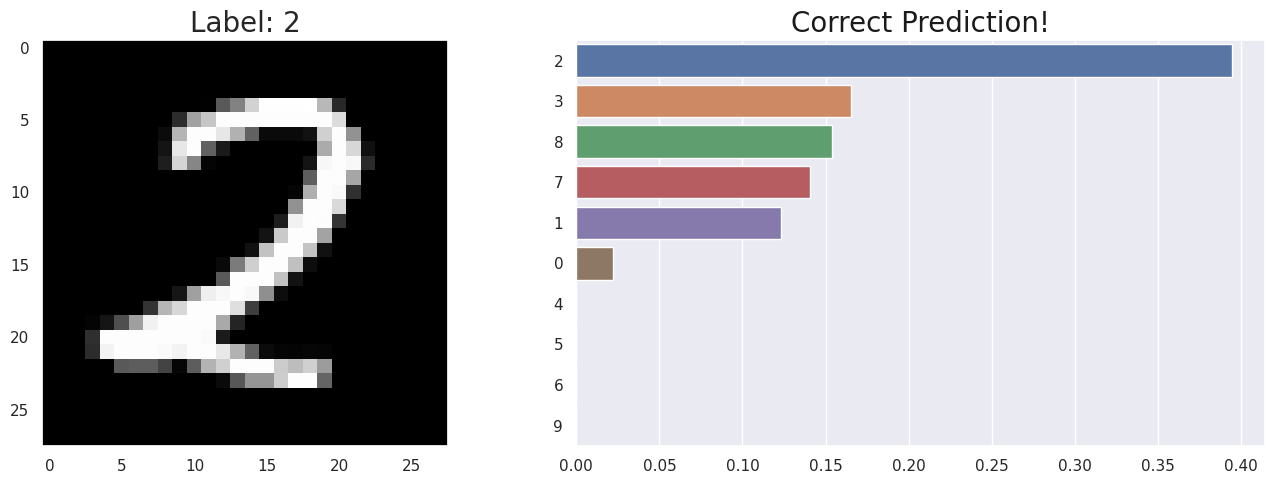

In [63]:
# evaluate on random samples from test dataloader
for i in np.random.randint(1000,size=5):
  eval(imgs[i],labels[i],cnn)

Note that our convolutional neural network is *more confident* than our fully
-connected neural network. That is,  more of the labels are 0, and the top prediction has a far larger bar than the rest. We can interpret this as a higher probability prediction for the top result with less uncertainty. ([Compare](#nwk_eval_test_sample) with the results for our fully-connected neural network.)

<a name='cnn_oos'></a>
Performace does not suffer when classifying previously unseen test data. However, while these data were held out of the training set, the stroke width and noise level is the same as the training set. Compare this with fully out-of-sample data below.

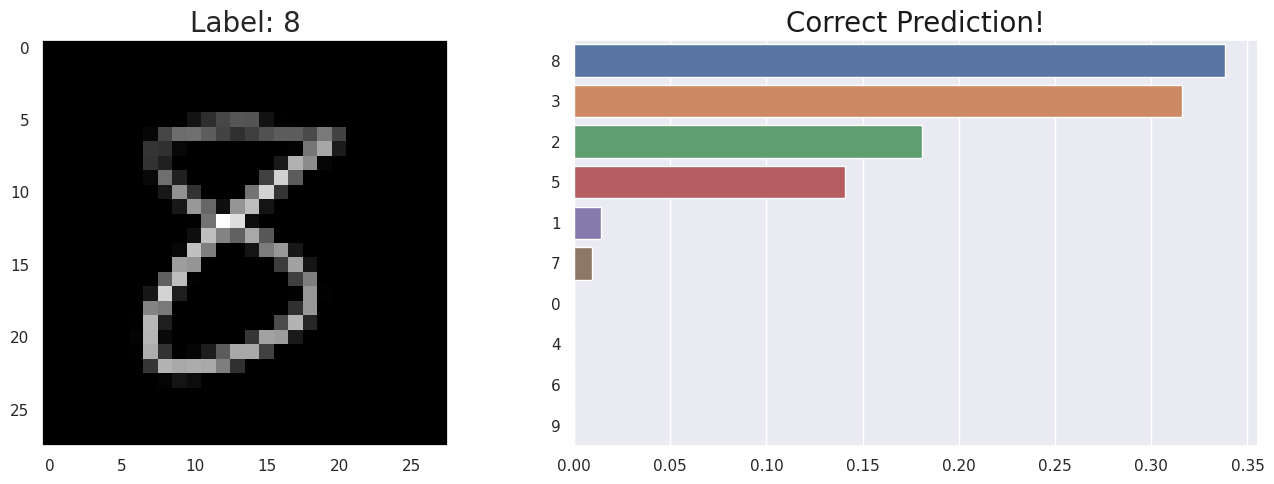

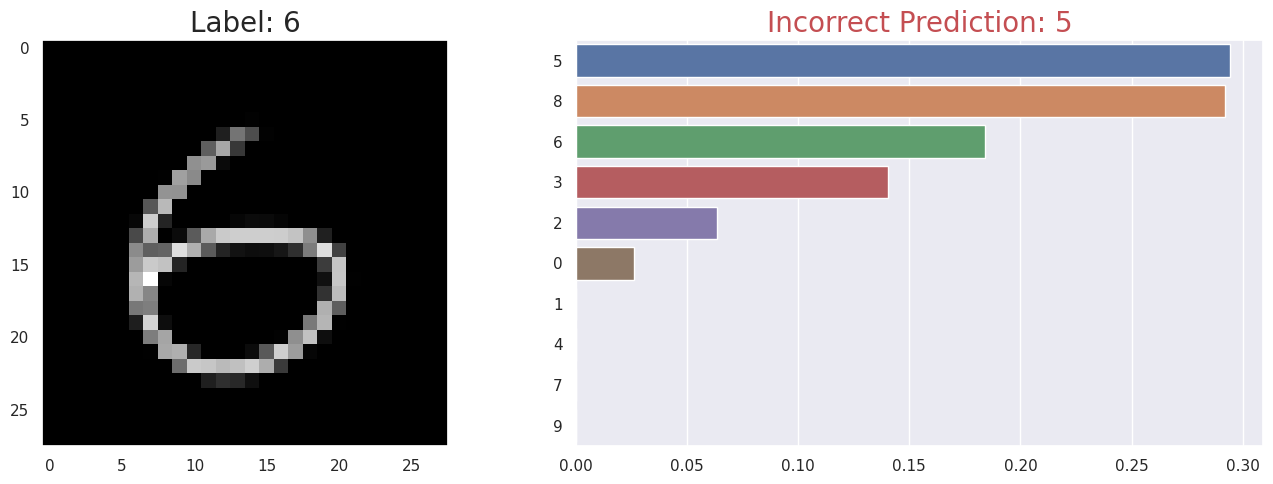

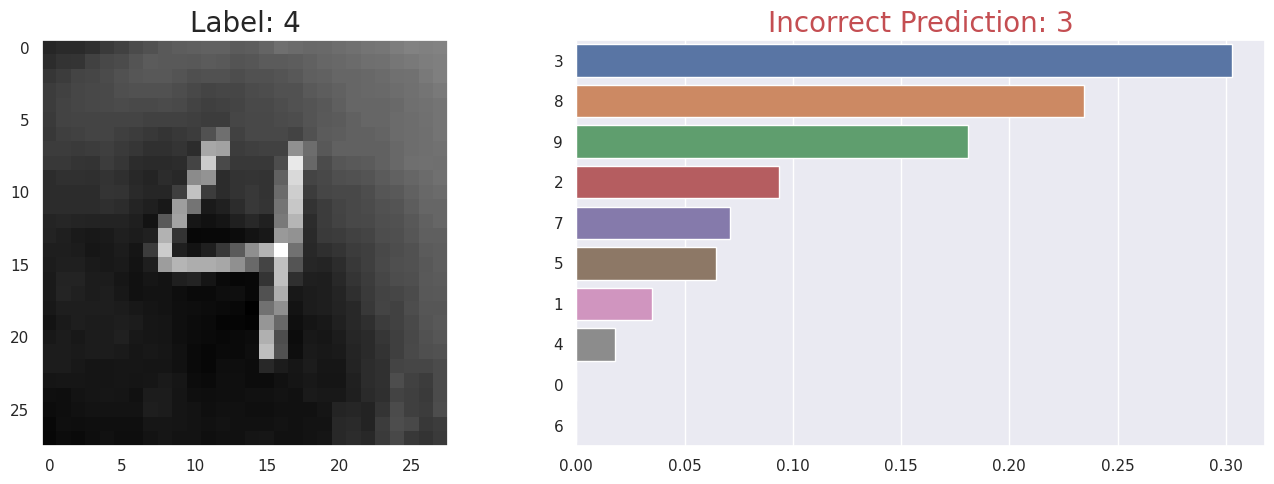

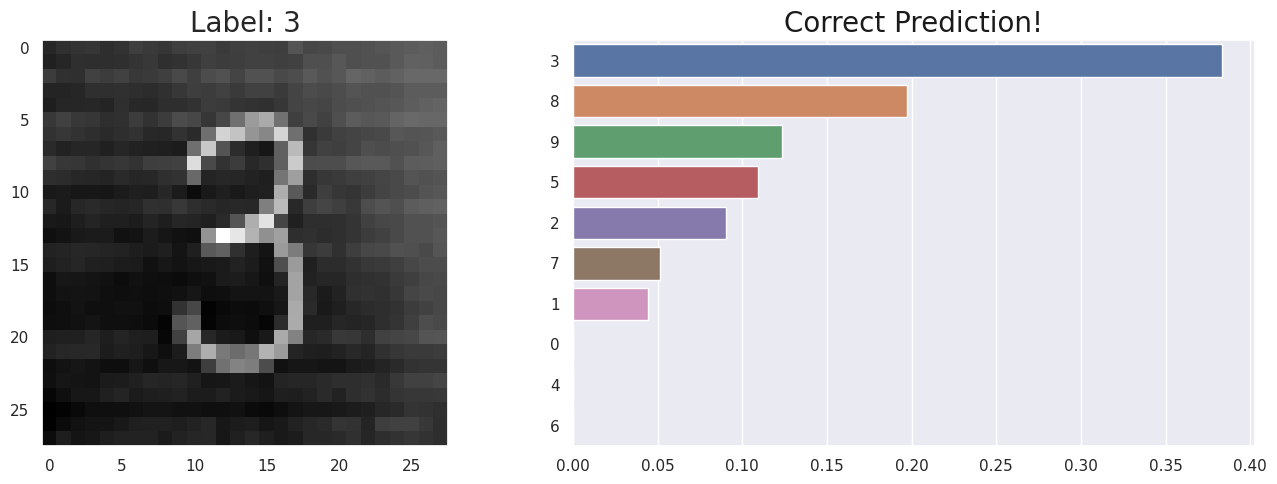

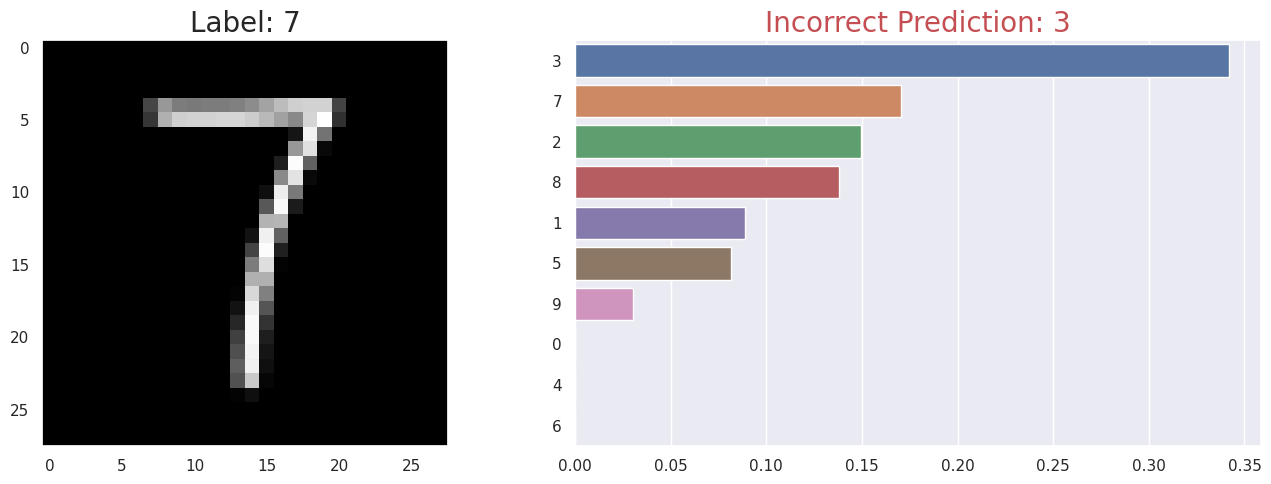

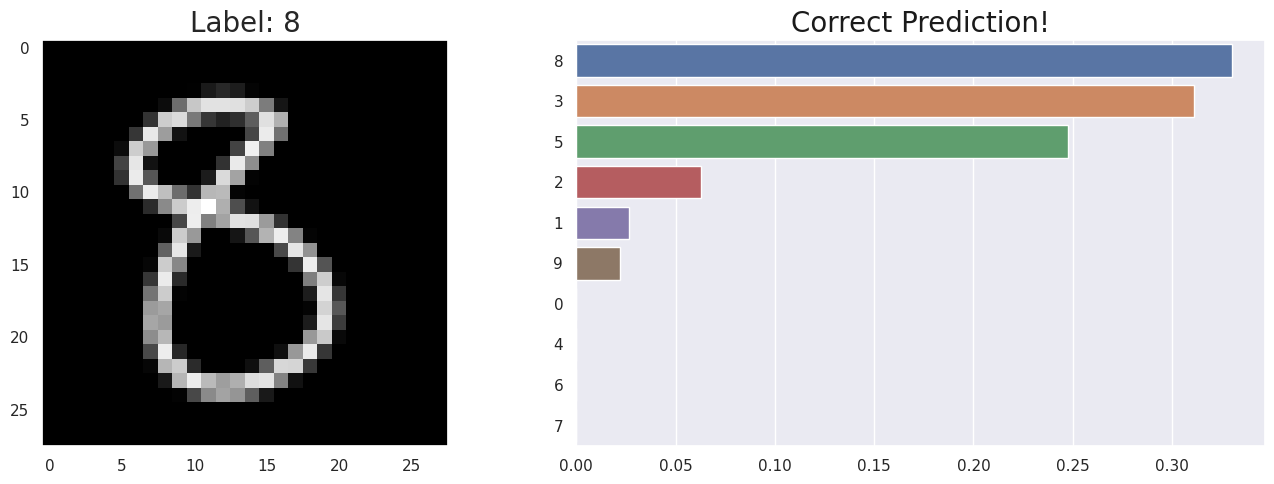

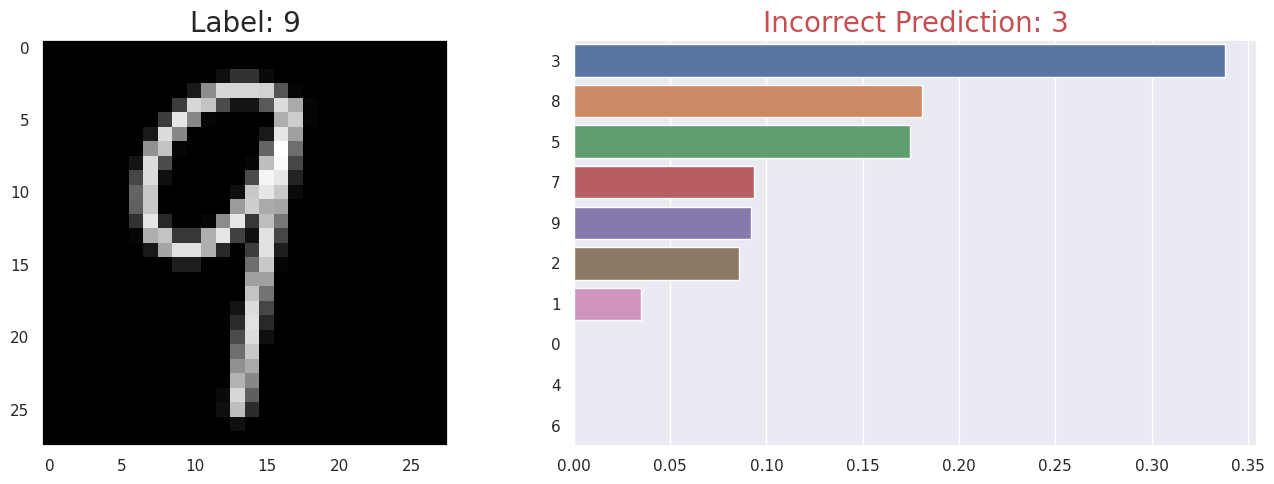

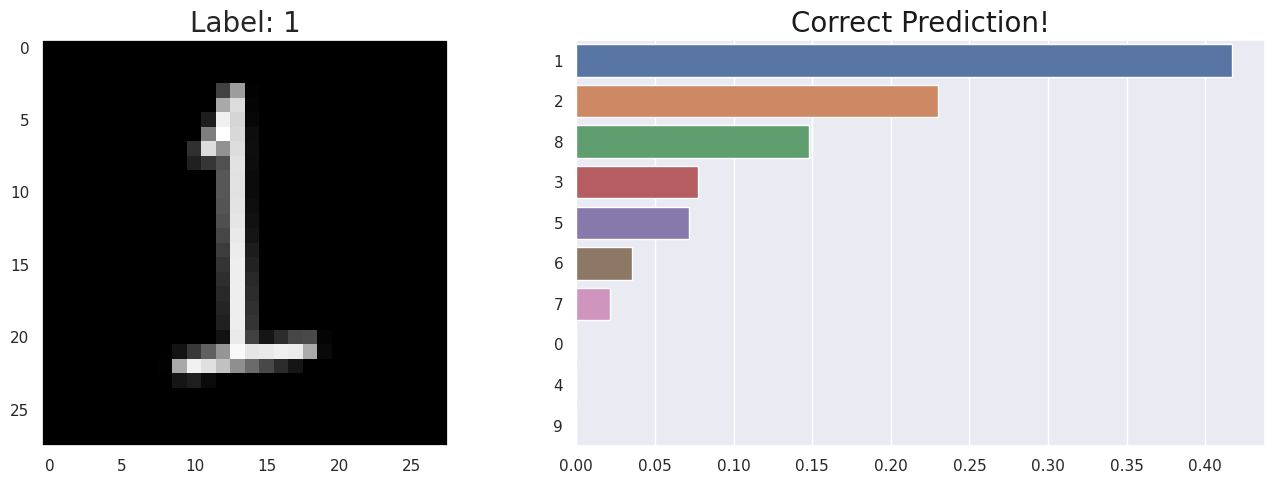

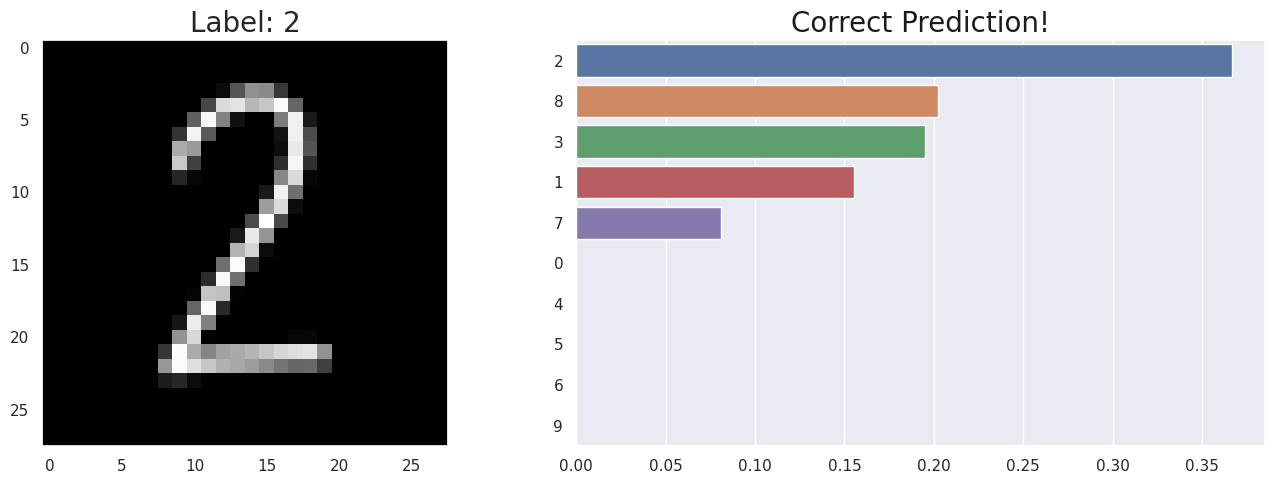

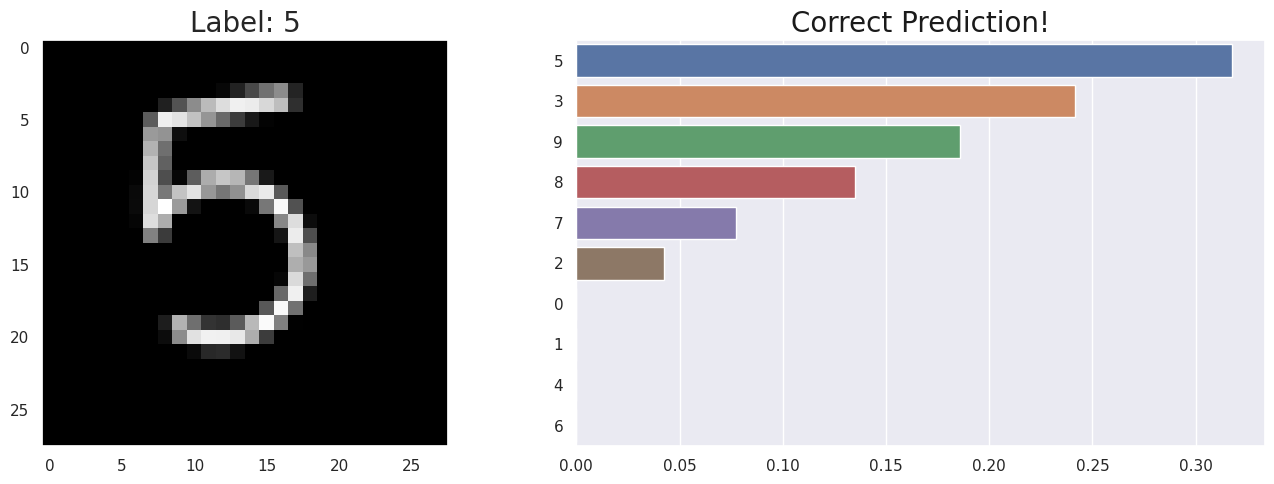

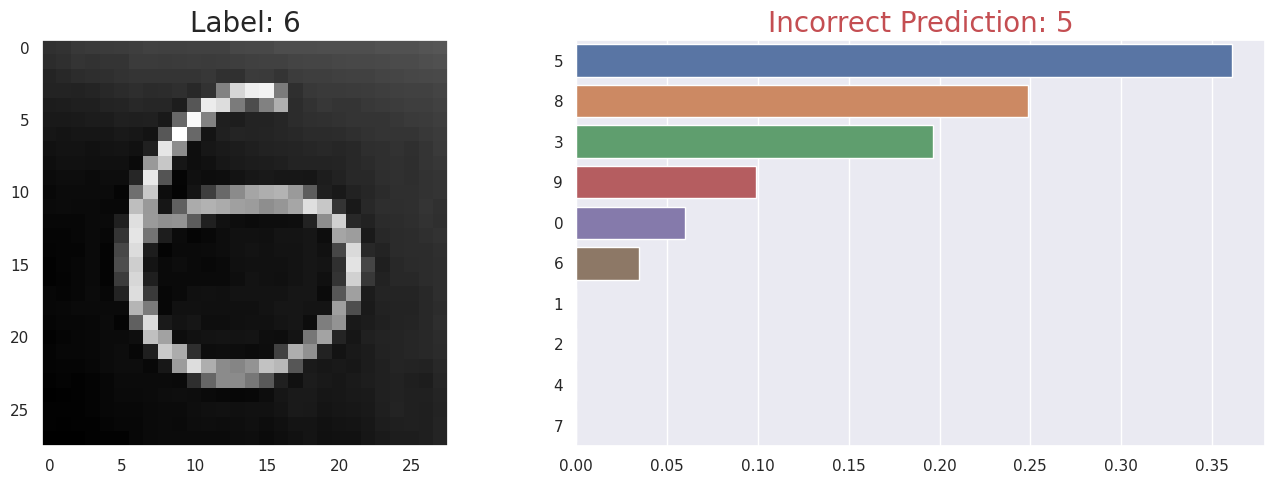

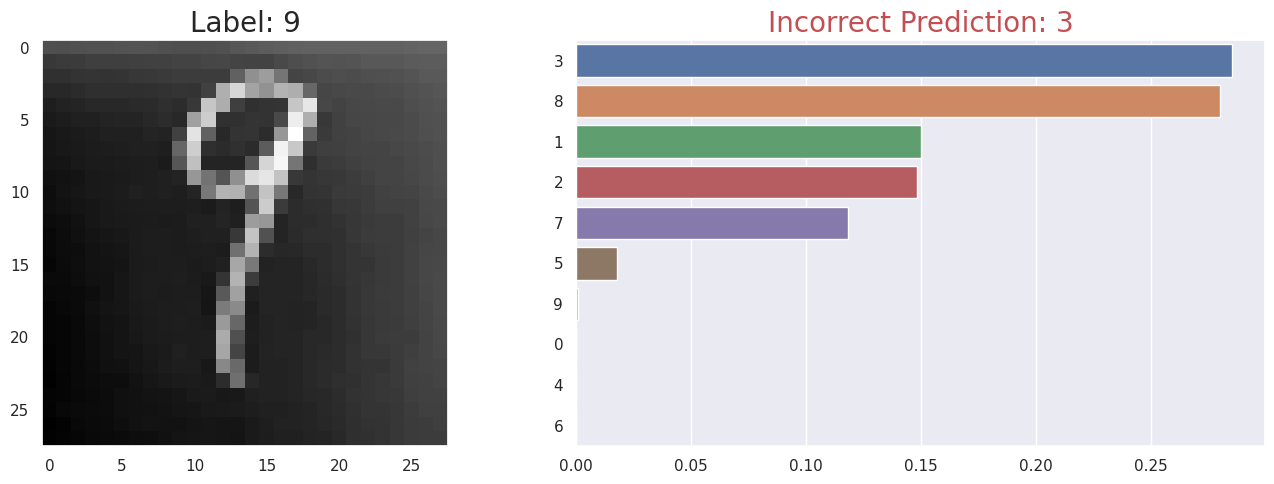

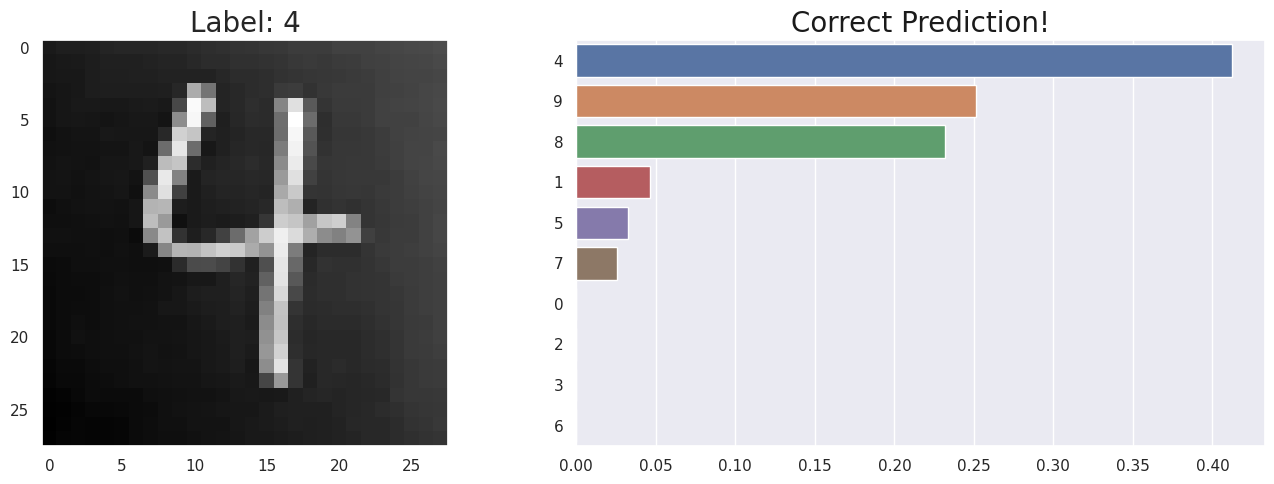

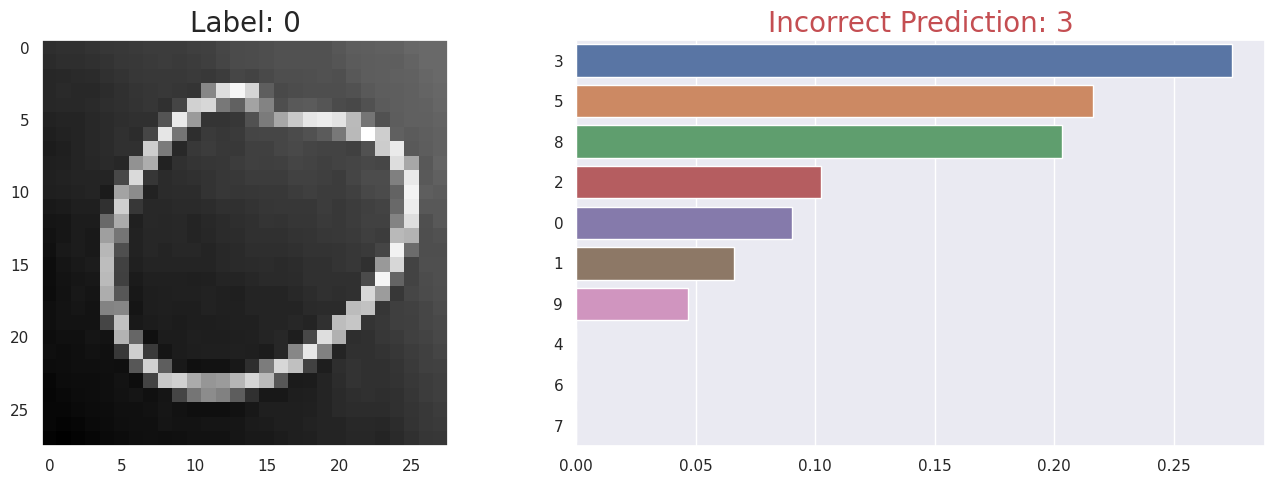


7 out of 14 misclassified.


In [64]:
eval_oos(cnn)

Again we have better performance than the fully-connected network, but accuracy is still terrible. Every prediction that our convolutional network missed was also missed by our fully-connected network, so it's not missing anything *new*. Notice as well that relative confidence has decreased, with a less pronounced top choice.

I think results can be improved going forward by introducing more noise into the training set. Additional progress could be made by varying the stroke width of the digits, but the former seems far easier to implement in Python without having to source new data.

Please [return to the top](#top) to see my portfolio and LinkedIn.